In [1]:
##### import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

import pandas as pd  
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import simplejson as json
import random

Using TensorFlow backend.


In [2]:
imgRow = 630
imgCol = 960

In [3]:
def showGrayImage(img):
    imgShow = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()
def CropImage(image):
    #Crops the iamge so that the hood of the car and top of the image
    #which contains sky trees and other stuffs are removed.
    height = len(image)
    return image[int(height * 2/5.):int(height * 6/7.0), :, :]

In [4]:
rootDir = "object-detection-crowdai/"
csvFile = pd.read_csv(rootDir+'labels.csv', header=0)

dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
dataFile['Frame'] = './' + rootDir + dataFile['Frame']
dataFile.columns = ['xmin', 'ymin', 'xmax','ymax', 'Frame', 'Label']
dataFile.head(10)

,xmin,ymin,xmax,ymax,Frame,Label
0,785,533,905,644,./object-detection-crowdai/1479498371963069978...,Car
1,89,551,291,680,./object-detection-crowdai/1479498371963069978...,Car
2,268,546,383,650,./object-detection-crowdai/1479498371963069978...,Car
3,455,522,548,615,./object-detection-crowdai/1479498371963069978...,Truck
4,548,522,625,605,./object-detection-crowdai/1479498371963069978...,Truck
5,1726,484,1919,646,./object-detection-crowdai/1479498371963069978...,Car
6,758,557,807,617,./object-detection-crowdai/1479498371963069978...,Car
7,633,561,680,597,./object-detection-crowdai/1479498371963069978...,Car
8,682,557,718,593,./object-detection-crowdai/1479498371963069978...,Car
9,710,540,836,665,./object-detection-crowdai/1479498372942264998...,Car


In [5]:
names = ['Frame',  'xmin', 'ymin', 'xmax','ymax', 'occluded', 'Label']
rootDir = "object-dataset/"
csvFile1 = pd.read_csv(rootDir+'labels.csv', delim_whitespace=True, names=names)
dataFile1 = csvFile1[(csvFile1['Label']!=str.lower('Pedestrian'))].reset_index()
dataFile1 = dataFile1.drop('index',1)
dataFile1 = dataFile1.drop('occluded',1)
dataFile1['Frame'] = './' + rootDir + dataFile1['Frame']
dataFile1.tail(10)


,Frame,xmin,ymin,xmax,ymax,Label
83210,./object-dataset/1478901535817639152.jpg,162,598,404,754,car
83211,./object-dataset/1478901535817639152.jpg,400,592,506,714,car
83212,./object-dataset/1478901535817639152.jpg,1118,556,1346,740,car
83213,./object-dataset/1478901536388465963.jpg,234,594,388,728,car
83214,./object-dataset/1478901536388465963.jpg,364,604,430,678,car
83215,./object-dataset/1478901536388465963.jpg,1048,552,1348,748,car
83216,./object-dataset/1478901536960505700.jpg,0,606,142,780,car
83217,./object-dataset/1478901536960505700.jpg,146,604,246,692,car
83218,./object-dataset/1478901536960505700.jpg,710,582,800,618,car
83219,./object-dataset/1478901536960505700.jpg,896,546,1228,790,car


In [6]:
dataFile.tail()

,xmin,ymin,xmax,ymax,Frame,Label
66384,958,559,1045,621,./object-detection-crowdai/1479506176491553178...,Car
66385,1038,558,1122,630,./object-detection-crowdai/1479506176491553178...,Car
66386,667,558,747,626,./object-detection-crowdai/1479506176491553178...,Car
66387,730,568,818,613,./object-detection-crowdai/1479506176491553178...,Car
66388,435,551,532,589,./object-detection-crowdai/1479506176491553178...,Car


In [7]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)


#result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

model loaded


./object-detection-crowdai/1479499805061835070.jpg 12130


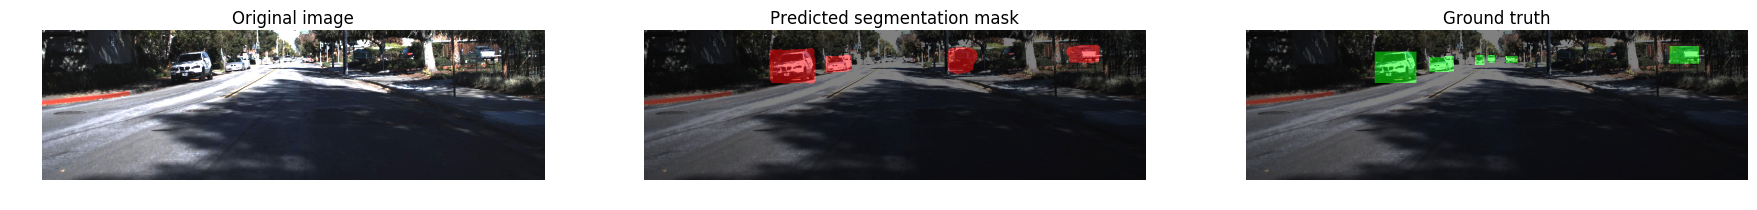

In [8]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 16
validationBatchSize = 64

def TrainDataGenerator(dataInfoList,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        dataInfo = dataInfoList[random.randint(0,1)]
        row = np.random.randint(len(dataInfo))
        fileName = dataInfo['Frame'][row]
        print(fileName, row)
        img = cv2.imread(fileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        origShape = img.shape
        img = cv2.resize(img, (imgCol, imgRow))
        
        data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
        data['xmin'] = np.round(data['xmin'] / origShape[1] * imgCol)
        data['xmax'] = np.round(data['xmax'] / origShape[1] * imgCol)
        data['ymin'] = np.round(data['ymin'] / origShape[0] * imgRow)
        data['ymax'] = np.round(data['ymax'] / origShape[0] * imgRow)
        
        targetImg = np.zeros_like(img[:, :, 2])
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1

        targetImg = np.reshape(targetImg, (imgRow, imgCol, 1))        
        targetImg = CropImage(targetImg)
        img = CropImage(img)
        
        
        xy_array = np.asarray(img)
        xy_array = np.reshape(xy_array,(1,img.shape[0],img.shape[1],3))
        
        img = model.predict(xy_array)
        mask_array  = np.reshape(targetImg,(1,targetImg.shape[0],targetImg.shape[1],1))
        
          
        im = np.array(xy_array[0],dtype=np.uint8)
        im_mask = np.array(255*mask_array[0],dtype=np.uint8)
        im_pred = np.array(255*img[0],dtype=np.uint8)

        rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
        rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
        rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
        rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
        rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

        img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
        img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

        plt.figure(figsize=(22,16))
        plt.subplot(1,3,1)
        plt.imshow(im)
        plt.title('Original image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(img_pred)
        plt.title('Predicted segmentation mask')
        plt.axis('off')
        plt.subplot(1,3,3)        
        plt.imshow(img_true)
        plt.title('Ground truth')
        plt.axis('off')
        plt.show()
        
        break
    
trainGenerator = TrainDataGenerator((dataFile,dataFile1),trainBatchSize,rootDir)    

In [9]:

def process_frame(img):
    img = cv2.resize(img,(imgCol,imgRow))    
    resizedImage = img.copy()
    img = CropImage(img)
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,img.shape[0],img.shape[1],3))
    
    img = model.predict(x_array,verbose=1)
    
    im = np.array(x_array[0],dtype=np.uint8)
    predImg = np.array(255*img[0],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(predImg,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    height = len(resizedImage)
    resizedImage[int(height * 2/5.):int(height * 6/7.0), :, :] = img_pred[:,:,:]
    
    return resizedImage

In [11]:

clip = VideoFileClip('./project_video.mp4')
outClip = clip.fl_image(process_frame)
%time outClip.write_videofile('./output_video.mp4', audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  0%|▏                                                                                | 3/1261 [00:00<00:49, 25.57it/s]

1/1 [==============================] - 0s


  0%|▍                                                                                | 6/1261 [00:00<00:49, 25.41it/s]

1/1 [==============================] - 0s


  1%|▌                                                                                | 9/1261 [00:00<00:49, 25.49it/s]

1/1 [==============================] - 0s


  1%|▊                                                                               | 12/1261 [00:00<00:48, 25.65it/s]

1/1 [==============================] - 0s


  1%|▉                                                                               | 15/1261 [00:00<00:48, 25.69it/s]

1/1 [==============================] - 0s


  1%|█▏                                                                              | 18/1261 [00:00<00:49, 25.01it/s]

1/1 [==============================] - 0s


  2%|█▎                                                                              | 21/1261 [00:00<00:49, 25.24it/s]

1/1 [==============================] - 0s


  2%|█▌                                                                              | 24/1261 [00:00<00:48, 25.44it/s]

1/1 [==============================] - 0s


  2%|█▋                                                                              | 27/1261 [00:01<00:48, 25.28it/s]

1/1 [==============================] - 0s


  2%|█▉                                                                              | 30/1261 [00:01<00:49, 25.11it/s]

1/1 [==============================] - 0s


  3%|██                                                                              | 33/1261 [00:01<00:48, 25.18it/s]

1/1 [==============================] - 0s


  3%|██▎                                                                             | 36/1261 [00:01<00:48, 25.21it/s]

1/1 [==============================] - 0s


  3%|██▍                                                                             | 39/1261 [00:01<00:48, 25.25it/s]

1/1 [==============================] - 0s


  3%|██▋                                                                             | 42/1261 [00:01<00:47, 25.41it/s]

1/1 [==============================] - 0s


  4%|██▊                                                                             | 45/1261 [00:01<00:47, 25.39it/s]

1/1 [==============================] - 0s


  4%|███                                                                             | 48/1261 [00:01<00:47, 25.58it/s]

1/1 [==============================] - 0s


  4%|███▏                                                                            | 51/1261 [00:02<00:46, 25.87it/s]

1/1 [==============================] - 0s


  4%|███▍                                                                            | 54/1261 [00:02<00:46, 26.01it/s]

1/1 [==============================] - 0s


  5%|███▌                                                                            | 57/1261 [00:02<00:46, 25.88it/s]

1/1 [==============================] - 0s


  5%|███▊                                                                            | 60/1261 [00:02<00:45, 26.16it/s]

1/1 [==============================] - 0s


  5%|███▉                                                                            | 63/1261 [00:02<00:45, 26.19it/s]

1/1 [==============================] - 0s


  5%|████▏                                                                           | 66/1261 [00:02<00:45, 26.10it/s]

1/1 [==============================] - 0s


  5%|████▍                                                                           | 69/1261 [00:02<00:45, 26.11it/s]

1/1 [==============================] - 0s


  6%|████▌                                                                           | 72/1261 [00:02<00:45, 26.22it/s]

1/1 [==============================] - 0s


  6%|████▊                                                                           | 75/1261 [00:02<00:45, 26.16it/s]

1/1 [==============================] - 0s


  6%|████▉                                                                           | 78/1261 [00:03<00:44, 26.39it/s]

1/1 [==============================] - 0s


  6%|█████▏                                                                          | 81/1261 [00:03<00:44, 26.52it/s]

1/1 [==============================] - 0s


  7%|█████▎                                                                          | 84/1261 [00:03<00:44, 26.69it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                          | 87/1261 [00:03<00:43, 26.80it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                          | 90/1261 [00:03<00:43, 26.74it/s]

1/1 [==============================] - 0s


  7%|█████▉                                                                          | 93/1261 [00:03<00:43, 26.63it/s]

1/1 [==============================] - 0s


  8%|██████                                                                          | 96/1261 [00:03<00:44, 26.44it/s]

1/1 [==============================] - 0s


  8%|██████▎                                                                         | 99/1261 [00:03<00:43, 26.49it/s]

1/1 [==============================] - 0s


  8%|██████▍                                                                        | 102/1261 [00:03<00:43, 26.66it/s]

1/1 [==============================] - 0s


  8%|██████▌                                                                        | 105/1261 [00:04<00:43, 26.57it/s]

1/1 [==============================] - 0s


  9%|██████▊                                                                        | 108/1261 [00:04<00:43, 26.23it/s]

1/1 [==============================] - 0s


  9%|██████▉                                                                        | 111/1261 [00:04<00:44, 25.96it/s]

1/1 [==============================] - 0s


  9%|███████▏                                                                       | 114/1261 [00:04<00:44, 25.74it/s]

1/1 [==============================] - 0s


  9%|███████▎                                                                       | 117/1261 [00:04<00:44, 25.99it/s]

1/1 [==============================] - 0s


 10%|███████▌                                                                       | 120/1261 [00:04<00:43, 26.00it/s]

1/1 [==============================] - 0s


 10%|███████▋                                                                       | 123/1261 [00:04<00:43, 26.01it/s]

1/1 [==============================] - 0s


 10%|███████▉                                                                       | 126/1261 [00:04<00:43, 26.04it/s]

1/1 [==============================] - 0s


 10%|████████                                                                       | 129/1261 [00:04<00:43, 25.93it/s]

1/1 [==============================] - 0s


 10%|████████▎                                                                      | 132/1261 [00:05<00:43, 26.09it/s]

1/1 [==============================] - 0s


 11%|████████▍                                                                      | 135/1261 [00:05<00:42, 26.28it/s]

1/1 [==============================] - 0s


 11%|████████▋                                                                      | 138/1261 [00:05<00:42, 26.58it/s]

1/1 [==============================] - 0s


 11%|████████▊                                                                      | 141/1261 [00:05<00:42, 26.52it/s]

1/1 [==============================] - 0s


 11%|█████████                                                                      | 144/1261 [00:05<00:42, 26.26it/s]

1/1 [==============================] - 0s


 12%|█████████▏                                                                     | 147/1261 [00:05<00:42, 26.29it/s]

1/1 [==============================] - 0s


 12%|█████████▍                                                                     | 150/1261 [00:05<00:42, 26.21it/s]

1/1 [==============================] - 0s


 12%|█████████▌                                                                     | 153/1261 [00:05<00:42, 26.36it/s]

1/1 [==============================] - 0s


 12%|█████████▊                                                                     | 156/1261 [00:05<00:41, 26.50it/s]

1/1 [==============================] - 0s


 13%|█████████▉                                                                     | 159/1261 [00:06<00:41, 26.60it/s]

1/1 [==============================] - 0s


 13%|██████████▏                                                                    | 162/1261 [00:06<00:41, 26.32it/s]

1/1 [==============================] - 0s


 13%|██████████▎                                                                    | 165/1261 [00:06<00:41, 26.16it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                    | 168/1261 [00:06<00:43, 25.32it/s]

1/1 [==============================] - 0s


 14%|██████████▋                                                                    | 171/1261 [00:06<00:44, 24.64it/s]

1/1 [==============================] - 0s


 14%|██████████▉                                                                    | 174/1261 [00:06<00:44, 24.67it/s]

1/1 [==============================] - 0s


 14%|███████████                                                                    | 177/1261 [00:06<00:42, 25.25it/s]

1/1 [==============================] - 0s


 14%|███████████▎                                                                   | 180/1261 [00:06<00:42, 25.74it/s]

1/1 [==============================] - 0s


 15%|███████████▍                                                                   | 183/1261 [00:07<00:41, 25.79it/s]

1/1 [==============================] - 0s


 15%|███████████▋                                                                   | 186/1261 [00:07<00:41, 25.89it/s]

1/1 [==============================] - 0s


 15%|███████████▊                                                                   | 189/1261 [00:07<00:41, 26.06it/s]

1/1 [==============================] - 0s


 15%|████████████                                                                   | 192/1261 [00:07<00:40, 26.39it/s]

1/1 [==============================] - 0s


 15%|████████████▏                                                                  | 195/1261 [00:07<00:40, 26.18it/s]

1/1 [==============================] - 0s


 16%|████████████▍                                                                  | 198/1261 [00:07<00:40, 26.30it/s]

1/1 [==============================] - 0s


 16%|████████████▌                                                                  | 201/1261 [00:07<00:40, 26.49it/s]

1/1 [==============================] - 0s


 16%|████████████▊                                                                  | 204/1261 [00:07<00:39, 26.45it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                  | 207/1261 [00:07<00:39, 26.64it/s]

1/1 [==============================] - 0s


 17%|█████████████▏                                                                 | 210/1261 [00:08<00:39, 26.66it/s]

1/1 [==============================] - 0s


 17%|█████████████▎                                                                 | 213/1261 [00:08<00:39, 26.68it/s]

1/1 [==============================] - 0s


 17%|█████████████▌                                                                 | 216/1261 [00:08<00:39, 26.44it/s]

1/1 [==============================] - 0s


 17%|█████████████▋                                                                 | 219/1261 [00:08<00:39, 26.24it/s]

1/1 [==============================] - 0s


 18%|█████████████▉                                                                 | 222/1261 [00:08<00:39, 26.35it/s]

1/1 [==============================] - 0s


 18%|██████████████                                                                 | 225/1261 [00:08<00:39, 26.35it/s]

1/1 [==============================] - 0s


 18%|██████████████▎                                                                | 228/1261 [00:08<00:39, 26.29it/s]

1/1 [==============================] - 0s


 18%|██████████████▍                                                                | 231/1261 [00:08<00:39, 26.24it/s]

1/1 [==============================] - 0s


 19%|██████████████▋                                                                | 234/1261 [00:08<00:39, 26.10it/s]

1/1 [==============================] - 0s


 19%|██████████████▊                                                                | 237/1261 [00:09<00:39, 26.15it/s]

1/1 [==============================] - 0s


 19%|███████████████                                                                | 240/1261 [00:09<00:38, 26.24it/s]

1/1 [==============================] - 0s


 19%|███████████████▏                                                               | 243/1261 [00:09<00:39, 26.04it/s]

1/1 [==============================] - 0s


 20%|███████████████▍                                                               | 246/1261 [00:09<00:38, 26.31it/s]

1/1 [==============================] - 0s


 20%|███████████████▌                                                               | 249/1261 [00:09<00:38, 26.39it/s]

1/1 [==============================] - 0s


 20%|███████████████▊                                                               | 252/1261 [00:09<00:38, 26.49it/s]

1/1 [==============================] - 0s


 20%|███████████████▉                                                               | 255/1261 [00:09<00:37, 26.49it/s]

1/1 [==============================] - 0s


 20%|████████████████▏                                                              | 258/1261 [00:09<00:37, 26.52it/s]

1/1 [==============================] - 0s


 21%|████████████████▎                                                              | 261/1261 [00:10<00:37, 26.68it/s]

1/1 [==============================] - 0s


 21%|████████████████▌                                                              | 264/1261 [00:10<00:37, 26.62it/s]

1/1 [==============================] - 0s


 21%|████████████████▋                                                              | 267/1261 [00:10<00:37, 26.58it/s]

1/1 [==============================] - 0s


 21%|████████████████▉                                                              | 270/1261 [00:10<00:37, 26.41it/s]

1/1 [==============================] - 0s


 22%|█████████████████                                                              | 273/1261 [00:10<00:37, 26.08it/s]

1/1 [==============================] - 0s


 22%|█████████████████▎                                                             | 276/1261 [00:10<00:37, 26.00it/s]

1/1 [==============================] - 0s


 22%|█████████████████▍                                                             | 279/1261 [00:10<00:37, 26.17it/s]

1/1 [==============================] - 0s


 22%|█████████████████▋                                                             | 282/1261 [00:10<00:37, 26.30it/s]

1/1 [==============================] - 0s


 23%|█████████████████▊                                                             | 285/1261 [00:10<00:37, 26.08it/s]

1/1 [==============================] - 0s


 23%|██████████████████                                                             | 288/1261 [00:11<00:37, 25.92it/s]

1/1 [==============================] - 0s


 23%|██████████████████▏                                                            | 291/1261 [00:11<00:37, 26.09it/s]

1/1 [==============================] - 0s


 23%|██████████████████▍                                                            | 294/1261 [00:11<00:37, 25.86it/s]

1/1 [==============================] - 0s


 24%|██████████████████▌                                                            | 297/1261 [00:11<00:37, 26.05it/s]

1/1 [==============================] - 0s


 24%|██████████████████▊                                                            | 300/1261 [00:11<00:36, 26.28it/s]

1/1 [==============================] - 0s


 24%|██████████████████▉                                                            | 303/1261 [00:11<00:36, 26.41it/s]

1/1 [==============================] - 0s


 24%|███████████████████▏                                                           | 306/1261 [00:11<00:36, 26.50it/s]

1/1 [==============================] - 0s


 25%|███████████████████▎                                                           | 309/1261 [00:11<00:36, 26.01it/s]

1/1 [==============================] - 0s


 25%|███████████████████▌                                                           | 312/1261 [00:11<00:36, 26.22it/s]

1/1 [==============================] - 0s


 25%|███████████████████▋                                                           | 315/1261 [00:12<00:36, 25.78it/s]

1/1 [==============================] - 0s


 25%|███████████████████▉                                                           | 318/1261 [00:12<00:36, 26.19it/s]

1/1 [==============================] - 0s


 25%|████████████████████                                                           | 321/1261 [00:12<00:36, 26.11it/s]

1/1 [==============================] - 0s


 26%|████████████████████▎                                                          | 324/1261 [00:12<00:36, 25.91it/s]

1/1 [==============================] - 0s


 26%|████████████████████▍                                                          | 327/1261 [00:12<00:35, 26.08it/s]

1/1 [==============================] - 0s


 26%|████████████████████▋                                                          | 330/1261 [00:12<00:36, 25.82it/s]

1/1 [==============================] - 0s


 26%|████████████████████▊                                                          | 333/1261 [00:12<00:35, 25.95it/s]

1/1 [==============================] - 0s


 27%|█████████████████████                                                          | 336/1261 [00:12<00:35, 26.04it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▏                                                         | 339/1261 [00:12<00:35, 26.10it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▍                                                         | 342/1261 [00:13<00:35, 26.21it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▌                                                         | 345/1261 [00:13<00:34, 26.29it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▊                                                         | 348/1261 [00:13<00:34, 26.38it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▉                                                         | 351/1261 [00:13<00:34, 26.07it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▏                                                        | 354/1261 [00:13<00:34, 26.19it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▎                                                        | 357/1261 [00:13<00:34, 25.90it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▌                                                        | 360/1261 [00:13<00:34, 25.97it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▋                                                        | 363/1261 [00:13<00:34, 26.09it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▉                                                        | 366/1261 [00:14<00:34, 26.03it/s]

1/1 [==============================] - 0s


 29%|███████████████████████                                                        | 369/1261 [00:14<00:34, 26.03it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▎                                                       | 372/1261 [00:14<00:34, 26.03it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▍                                                       | 375/1261 [00:14<00:34, 25.89it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▋                                                       | 378/1261 [00:14<00:33, 26.13it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▊                                                       | 381/1261 [00:14<00:33, 26.13it/s]

1/1 [==============================] - 0s


 30%|████████████████████████                                                       | 384/1261 [00:14<00:33, 26.10it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▏                                                      | 387/1261 [00:14<00:33, 26.14it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▍                                                      | 390/1261 [00:14<00:33, 26.07it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▌                                                      | 393/1261 [00:15<00:33, 25.92it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▊                                                      | 396/1261 [00:15<00:33, 25.78it/s]

1/1 [==============================] - 0s


 32%|████████████████████████▉                                                      | 399/1261 [00:15<00:33, 26.05it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▏                                                     | 402/1261 [00:15<00:32, 26.32it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▎                                                     | 405/1261 [00:15<00:32, 26.37it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▌                                                     | 408/1261 [00:15<00:32, 26.23it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▋                                                     | 411/1261 [00:15<00:32, 26.16it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▉                                                     | 414/1261 [00:15<00:32, 26.12it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████                                                     | 417/1261 [00:15<00:32, 26.36it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▎                                                    | 420/1261 [00:16<00:31, 26.43it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▌                                                    | 423/1261 [00:16<00:31, 26.61it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▋                                                    | 426/1261 [00:16<00:31, 26.68it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▉                                                    | 429/1261 [00:16<00:31, 26.44it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████                                                    | 432/1261 [00:16<00:31, 26.63it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▎                                                   | 435/1261 [00:16<00:30, 26.73it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▍                                                   | 438/1261 [00:16<00:30, 26.87it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▋                                                   | 441/1261 [00:16<00:30, 26.68it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▊                                                   | 444/1261 [00:16<00:30, 26.48it/s]

1/1 [==============================] - 0s


 35%|████████████████████████████                                                   | 447/1261 [00:17<00:32, 25.33it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▏                                                  | 450/1261 [00:17<00:32, 25.18it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▍                                                  | 453/1261 [00:17<00:32, 25.23it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▌                                                  | 456/1261 [00:17<00:31, 25.33it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▊                                                  | 459/1261 [00:17<00:31, 25.54it/s]

1/1 [==============================] - 0s


 37%|████████████████████████████▉                                                  | 462/1261 [00:17<00:30, 25.88it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▏                                                 | 465/1261 [00:17<00:30, 26.09it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▎                                                 | 468/1261 [00:17<00:30, 26.20it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▌                                                 | 471/1261 [00:18<00:30, 26.32it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▋                                                 | 474/1261 [00:18<00:29, 26.40it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▉                                                 | 477/1261 [00:18<00:29, 26.22it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████                                                 | 480/1261 [00:18<00:29, 26.19it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▎                                                | 483/1261 [00:18<00:29, 26.49it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▍                                                | 486/1261 [00:18<00:29, 26.59it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▋                                                | 489/1261 [00:18<00:28, 26.81it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▊                                                | 492/1261 [00:18<00:28, 26.60it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████                                                | 495/1261 [00:18<00:28, 26.42it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▏                                               | 498/1261 [00:19<00:28, 26.37it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▍                                               | 501/1261 [00:19<00:28, 26.33it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▌                                               | 504/1261 [00:19<00:28, 26.38it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▊                                               | 507/1261 [00:19<00:28, 26.55it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▉                                               | 510/1261 [00:19<00:28, 26.46it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▏                                              | 513/1261 [00:19<00:28, 26.22it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▎                                              | 516/1261 [00:19<00:28, 26.30it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▌                                              | 519/1261 [00:19<00:28, 26.39it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▋                                              | 522/1261 [00:19<00:28, 26.38it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▉                                              | 525/1261 [00:20<00:28, 26.16it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████                                              | 528/1261 [00:20<00:27, 26.26it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▎                                             | 531/1261 [00:20<00:27, 26.50it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▍                                             | 534/1261 [00:20<00:27, 26.42it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▋                                             | 537/1261 [00:20<00:28, 25.56it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▊                                             | 540/1261 [00:20<00:27, 25.89it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████                                             | 543/1261 [00:20<00:27, 26.10it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▏                                            | 546/1261 [00:20<00:27, 26.08it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▍                                            | 549/1261 [00:21<00:27, 26.13it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▌                                            | 552/1261 [00:21<00:27, 26.06it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▊                                            | 555/1261 [00:21<00:27, 25.98it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▉                                            | 558/1261 [00:21<00:26, 26.13it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▏                                           | 561/1261 [00:21<00:26, 26.30it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▎                                           | 564/1261 [00:21<00:26, 26.01it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▌                                           | 567/1261 [00:21<00:26, 25.95it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▋                                           | 570/1261 [00:21<00:26, 25.67it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▉                                           | 573/1261 [00:21<00:27, 25.31it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████                                           | 576/1261 [00:22<00:26, 25.75it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▎                                          | 579/1261 [00:22<00:26, 26.10it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▍                                          | 582/1261 [00:22<00:25, 26.25it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▋                                          | 585/1261 [00:22<00:25, 26.35it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▊                                          | 588/1261 [00:22<00:25, 26.15it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████                                          | 591/1261 [00:22<00:25, 26.07it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:22<00:25, 25.96it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▍                                         | 597/1261 [00:22<00:25, 25.94it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:22<00:25, 25.83it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▊                                         | 603/1261 [00:23<00:25, 25.99it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:23<00:25, 26.00it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▏                                        | 609/1261 [00:23<00:24, 26.17it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:23<00:24, 26.44it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▌                                        | 615/1261 [00:23<00:24, 26.41it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:23<00:24, 26.26it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▉                                        | 621/1261 [00:23<00:24, 26.32it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████                                        | 624/1261 [00:23<00:24, 26.44it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▎                                       | 627/1261 [00:24<00:23, 26.49it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:24<00:23, 26.66it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▋                                       | 633/1261 [00:24<00:23, 26.71it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:24<00:23, 26.64it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████                                       | 639/1261 [00:24<00:23, 26.77it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▏                                      | 642/1261 [00:24<00:23, 26.86it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▍                                      | 645/1261 [00:24<00:23, 26.75it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▌                                      | 648/1261 [00:24<00:22, 26.77it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▊                                      | 651/1261 [00:24<00:22, 26.86it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▉                                      | 654/1261 [00:25<00:22, 26.96it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▏                                     | 657/1261 [00:25<00:22, 26.81it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:25<00:22, 26.50it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▌                                     | 663/1261 [00:25<00:22, 26.32it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:25<00:22, 26.06it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▉                                     | 669/1261 [00:25<00:22, 25.88it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████                                     | 672/1261 [00:25<00:22, 26.26it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▎                                    | 675/1261 [00:25<00:22, 26.22it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:25<00:22, 25.85it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▋                                    | 681/1261 [00:26<00:22, 25.51it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:26<00:22, 25.62it/s]

1/1 [==============================] - 0s


 54%|███████████████████████████████████████████                                    | 687/1261 [00:26<00:22, 25.84it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:26<00:21, 26.23it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▍                                   | 693/1261 [00:26<00:21, 26.38it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:26<00:21, 26.48it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▊                                   | 699/1261 [00:26<00:21, 26.41it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:26<00:21, 26.60it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▏                                  | 705/1261 [00:26<00:20, 26.53it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:27<00:20, 26.48it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▌                                  | 711/1261 [00:27<00:20, 26.44it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▋                                  | 714/1261 [00:27<00:20, 26.21it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▉                                  | 717/1261 [00:27<00:20, 26.12it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████                                  | 720/1261 [00:27<00:20, 26.29it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [00:27<00:20, 26.38it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [00:27<00:20, 26.41it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [00:27<00:20, 26.36it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [00:27<00:20, 26.29it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████                                 | 735/1261 [00:28<00:20, 26.14it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▏                                | 738/1261 [00:28<00:19, 26.24it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▍                                | 741/1261 [00:28<00:19, 26.07it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▌                                | 744/1261 [00:28<00:20, 25.72it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▊                                | 747/1261 [00:28<00:19, 25.98it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▉                                | 750/1261 [00:28<00:19, 25.95it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▏                               | 753/1261 [00:28<00:19, 25.74it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▎                               | 756/1261 [00:28<00:19, 26.06it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▌                               | 759/1261 [00:29<00:19, 26.15it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▋                               | 762/1261 [00:29<00:18, 26.28it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▉                               | 765/1261 [00:29<00:18, 26.44it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████                               | 768/1261 [00:29<00:18, 26.38it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▎                              | 771/1261 [00:29<00:18, 26.24it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▍                              | 774/1261 [00:29<00:18, 26.24it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▋                              | 777/1261 [00:29<00:18, 26.49it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▊                              | 780/1261 [00:29<00:18, 26.45it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████                              | 783/1261 [00:29<00:17, 26.63it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [00:30<00:17, 26.41it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [00:30<00:17, 26.26it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [00:30<00:17, 26.18it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [00:30<00:17, 26.24it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [00:30<00:17, 26.38it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [00:30<00:17, 26.37it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [00:30<00:17, 26.51it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [00:30<00:17, 26.26it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [00:30<00:17, 26.15it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [00:31<00:17, 26.25it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████                            | 816/1261 [00:31<00:16, 26.42it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [00:31<00:16, 26.20it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [00:31<00:16, 26.18it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [00:31<00:17, 25.59it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [00:31<00:16, 25.55it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████                           | 831/1261 [00:31<00:16, 25.82it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [00:31<00:16, 26.07it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [00:31<00:16, 26.16it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [00:32<00:16, 26.29it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [00:32<00:16, 25.87it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████                          | 846/1261 [00:32<00:15, 26.01it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [00:32<00:15, 26.02it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [00:32<00:15, 26.05it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [00:32<00:15, 25.84it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [00:32<00:15, 25.66it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [00:32<00:15, 25.18it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [00:33<00:15, 25.30it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [00:33<00:15, 25.22it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [00:33<00:15, 25.29it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [00:33<00:15, 24.87it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [00:33<00:15, 25.27it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████                        | 879/1261 [00:33<00:15, 25.46it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [00:33<00:14, 25.59it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [00:33<00:14, 25.68it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [00:33<00:14, 25.85it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [00:34<00:14, 26.17it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████                       | 894/1261 [00:34<00:13, 26.23it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [00:34<00:13, 26.27it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [00:34<00:13, 26.30it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [00:34<00:13, 26.42it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [00:34<00:13, 26.16it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [00:34<00:13, 26.36it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [00:34<00:13, 26.46it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [00:35<00:13, 26.33it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [00:35<00:13, 26.34it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [00:35<00:12, 26.45it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [00:35<00:12, 26.42it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [00:35<00:12, 26.40it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [00:35<00:12, 26.08it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [00:35<00:12, 26.34it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [00:35<00:12, 26.34it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [00:35<00:12, 26.28it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [00:36<00:12, 26.37it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [00:36<00:11, 26.41it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [00:36<00:11, 26.32it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [00:36<00:11, 26.16it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [00:36<00:11, 26.08it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [00:36<00:11, 25.76it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [00:36<00:11, 25.97it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [00:36<00:11, 26.02it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [00:36<00:11, 26.16it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [00:37<00:11, 26.32it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [00:37<00:10, 26.37it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [00:37<00:10, 26.16it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [00:37<00:10, 26.25it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [00:37<00:10, 26.50it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [00:37<00:10, 26.35it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [00:37<00:10, 26.28it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [00:37<00:10, 26.20it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [00:37<00:10, 26.08it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [00:38<00:10, 26.20it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [00:38<00:09, 26.21it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [00:38<00:09, 26.02it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [00:38<00:09, 26.29it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [00:38<00:09, 26.49it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [00:38<00:09, 26.45it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [00:38<00:09, 26.32it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [00:38<00:09, 26.23it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [00:39<00:09, 26.27it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [00:39<00:09, 26.09it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [00:39<00:08, 26.14it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [00:39<00:08, 26.27it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [00:39<00:08, 26.44it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [00:39<00:08, 26.31it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [00:39<00:08, 26.29it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [00:39<00:08, 26.28it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [00:39<00:08, 26.44it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [00:40<00:08, 26.56it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [00:40<00:07, 26.46it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [00:40<00:07, 26.54it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [00:40<00:07, 26.59it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [00:40<00:07, 26.49it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [00:40<00:07, 26.03it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [00:40<00:07, 26.10it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [00:40<00:07, 26.21it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [00:40<00:07, 26.08it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [00:41<00:07, 26.20it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [00:41<00:07, 25.94it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [00:41<00:07, 25.76it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [00:41<00:06, 25.84it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [00:41<00:06, 25.76it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [00:41<00:06, 25.54it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [00:41<00:06, 25.58it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [00:41<00:06, 25.45it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [00:42<00:06, 25.58it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [00:42<00:06, 25.85it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [00:42<00:06, 26.13it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [00:42<00:05, 26.27it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [00:42<00:05, 26.26it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [00:42<00:05, 26.43it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [00:42<00:05, 26.45it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [00:42<00:05, 26.60it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [00:42<00:05, 26.25it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [00:43<00:05, 25.71it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [00:43<00:05, 25.73it/s]

1/1 [==============================] - 0s


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [00:43<00:05, 25.52it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [00:43<00:04, 25.54it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [00:43<00:04, 25.81it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [00:43<00:04, 26.01it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [00:43<00:04, 25.98it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [00:43<00:04, 26.02it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [00:43<00:04, 26.23it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [00:44<00:04, 26.23it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [00:44<00:04, 26.17it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [00:44<00:03, 25.85it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [00:44<00:03, 25.21it/s]

1/1 [==============================] - 0s


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [00:44<00:03, 25.07it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [00:44<00:03, 25.15it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [00:44<00:03, 25.50it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [00:44<00:03, 25.92it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [00:45<00:03, 25.98it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [00:45<00:03, 25.86it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [00:45<00:03, 25.74it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [00:45<00:02, 25.82it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [00:45<00:02, 25.91it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [00:45<00:02, 26.18it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [00:45<00:02, 26.31it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [00:45<00:02, 26.36it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [00:45<00:02, 26.25it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [00:46<00:02, 26.53it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [00:46<00:02, 26.52it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [00:46<00:01, 26.50it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [00:46<00:01, 26.67it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [00:46<00:01, 26.72it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [00:46<00:01, 26.58it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [00:46<00:01, 26.48it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [00:46<00:01, 26.55it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [00:46<00:01, 26.63it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [00:47<00:01, 26.48it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [00:47<00:01, 26.31it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [00:47<00:00, 25.48it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [00:47<00:00, 25.57it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [00:47<00:00, 25.71it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [00:47<00:00, 25.73it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [00:47<00:00, 25.88it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [00:47<00:00, 26.03it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [00:47<00:00, 26.13it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [00:48<00:00, 26.09it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:48<00:00, 26.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

Wall time: 48.7 s


In [12]:
clip = VideoFileClip('./challenge_video.mp4')
outClip = clip.fl_image(process_frame)
%time outClip.write_videofile('./output_video_challenge.mp4', audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video ./output_video_challenge.mp4
[MoviePy] Writing video ./output_video_challenge.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  1%|▌                                                                                 | 3/485 [00:00<00:19, 25.36it/s]

1/1 [==============================] - 0s


  1%|█                                                                                 | 6/485 [00:00<00:18, 25.23it/s]

1/1 [==============================] - 0s


  2%|█▌                                                                                | 9/485 [00:00<00:18, 25.17it/s]

1/1 [==============================] - 0s


  2%|██                                                                               | 12/485 [00:00<00:18, 25.04it/s]

1/1 [==============================] - 0s


  3%|██▌                                                                              | 15/485 [00:00<00:18, 25.16it/s]

1/1 [==============================] - 0s


  4%|███                                                                              | 18/485 [00:00<00:18, 25.16it/s]

1/1 [==============================] - 0s


  4%|███▌                                                                             | 21/485 [00:00<00:18, 24.84it/s]

1/1 [==============================] - 0s


  5%|████                                                                             | 24/485 [00:00<00:18, 25.12it/s]

1/1 [==============================] - 0s


  6%|████▌                                                                            | 27/485 [00:01<00:18, 25.31it/s]

1/1 [==============================] - 0s


  6%|█████                                                                            | 30/485 [00:01<00:17, 25.39it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                           | 33/485 [00:01<00:17, 25.61it/s]

1/1 [==============================] - 0s


  7%|██████                                                                           | 36/485 [00:01<00:17, 25.53it/s]

1/1 [==============================] - 0s


  8%|██████▌                                                                          | 39/485 [00:01<00:17, 25.45it/s]

1/1 [==============================] - 0s


  9%|███████                                                                          | 42/485 [00:01<00:17, 25.10it/s]

1/1 [==============================] - 0s


  9%|███████▌                                                                         | 45/485 [00:01<00:17, 24.96it/s]

1/1 [==============================] - 0s


 10%|████████                                                                         | 48/485 [00:01<00:17, 25.11it/s]

1/1 [==============================] - 0s


 11%|████████▌                                                                        | 51/485 [00:02<00:17, 25.18it/s]

1/1 [==============================] - 0s


 11%|█████████                                                                        | 54/485 [00:02<00:16, 25.36it/s]

1/1 [==============================] - 0s


 12%|█████████▌                                                                       | 57/485 [00:02<00:16, 25.39it/s]

1/1 [==============================] - 0s


 12%|██████████                                                                       | 60/485 [00:02<00:16, 25.41it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                      | 63/485 [00:02<00:16, 25.24it/s]

1/1 [==============================] - 0s


 14%|███████████                                                                      | 66/485 [00:02<00:16, 25.02it/s]

1/1 [==============================] - 0s


 14%|███████████▌                                                                     | 69/485 [00:02<00:16, 25.28it/s]

1/1 [==============================] - 0s


 15%|████████████                                                                     | 72/485 [00:02<00:16, 25.46it/s]

1/1 [==============================] - 0s


 15%|████████████▌                                                                    | 75/485 [00:02<00:16, 25.56it/s]

1/1 [==============================] - 0s


 16%|█████████████                                                                    | 78/485 [00:03<00:15, 25.80it/s]

1/1 [==============================] - 0s


 17%|█████████████▌                                                                   | 81/485 [00:03<00:15, 26.00it/s]

1/1 [==============================] - 0s


 17%|██████████████                                                                   | 84/485 [00:03<00:15, 26.04it/s]

1/1 [==============================] - 0s


 18%|██████████████▌                                                                  | 87/485 [00:03<00:15, 25.96it/s]

1/1 [==============================] - 0s


 19%|███████████████                                                                  | 90/485 [00:03<00:15, 26.05it/s]

1/1 [==============================] - 0s


 19%|███████████████▌                                                                 | 93/485 [00:03<00:15, 25.94it/s]

1/1 [==============================] - 0s


 20%|████████████████                                                                 | 96/485 [00:03<00:14, 25.96it/s]

1/1 [==============================] - 0s


 20%|████████████████▌                                                                | 99/485 [00:03<00:14, 26.18it/s]

1/1 [==============================] - 0s


 21%|████████████████▊                                                               | 102/485 [00:04<00:14, 26.10it/s]

1/1 [==============================] - 0s


 22%|█████████████████▎                                                              | 105/485 [00:04<00:14, 25.94it/s]

1/1 [==============================] - 0s


 22%|█████████████████▊                                                              | 108/485 [00:04<00:14, 25.34it/s]

1/1 [==============================] - 0s


 23%|██████████████████▎                                                             | 111/485 [00:04<00:14, 25.31it/s]

1/1 [==============================] - 0s


 24%|██████████████████▊                                                             | 114/485 [00:04<00:14, 25.10it/s]

1/1 [==============================] - 0s


 24%|███████████████████▎                                                            | 117/485 [00:04<00:15, 23.74it/s]

1/1 [==============================] - 0s


 25%|███████████████████▊                                                            | 120/485 [00:04<00:15, 23.71it/s]

1/1 [==============================] - 0s


 25%|████████████████████▎                                                           | 123/485 [00:04<00:15, 23.98it/s]

1/1 [==============================] - 0s


 26%|████████████████████▊                                                           | 126/485 [00:04<00:14, 24.11it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▎                                                          | 129/485 [00:05<00:14, 24.29it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▊                                                          | 132/485 [00:05<00:14, 24.36it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▎                                                         | 135/485 [00:05<00:14, 24.44it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▊                                                         | 138/485 [00:05<00:14, 24.50it/s]

1/1 [==============================] - 0s


 29%|███████████████████████▎                                                        | 141/485 [00:05<00:14, 24.44it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▊                                                        | 144/485 [00:05<00:13, 24.59it/s]

1/1 [==============================] - 0s


 30%|████████████████████████▏                                                       | 147/485 [00:05<00:13, 24.21it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▋                                                       | 150/485 [00:05<00:14, 23.87it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▏                                                      | 153/485 [00:06<00:13, 23.89it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▋                                                      | 156/485 [00:06<00:13, 24.19it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▏                                                     | 159/485 [00:06<00:13, 24.47it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▋                                                     | 162/485 [00:06<00:13, 24.52it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▏                                                    | 165/485 [00:06<00:12, 24.82it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▋                                                    | 168/485 [00:06<00:12, 24.86it/s]

1/1 [==============================] - 0s


 35%|████████████████████████████▏                                                   | 171/485 [00:06<00:12, 24.73it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▋                                                   | 174/485 [00:06<00:12, 24.97it/s]

1/1 [==============================] - 0s


 36%|█████████████████████████████▏                                                  | 177/485 [00:07<00:12, 25.12it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▋                                                  | 180/485 [00:07<00:12, 25.13it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▏                                                 | 183/485 [00:07<00:12, 25.01it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▋                                                 | 186/485 [00:07<00:11, 25.01it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▏                                                | 189/485 [00:07<00:11, 24.87it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▋                                                | 192/485 [00:07<00:11, 24.79it/s]

1/1 [==============================] - 0s


 40%|████████████████████████████████▏                                               | 195/485 [00:07<00:11, 24.87it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▋                                               | 198/485 [00:07<00:11, 24.98it/s]

1/1 [==============================] - 0s


 41%|█████████████████████████████████▏                                              | 201/485 [00:08<00:11, 25.00it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▋                                              | 204/485 [00:08<00:11, 24.88it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▏                                             | 207/485 [00:08<00:11, 24.74it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▋                                             | 210/485 [00:08<00:11, 24.83it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▏                                            | 213/485 [00:08<00:10, 24.80it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▋                                            | 216/485 [00:08<00:10, 24.96it/s]

1/1 [==============================] - 0s


 45%|████████████████████████████████████                                            | 219/485 [00:08<00:10, 25.08it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▌                                           | 222/485 [00:08<00:10, 24.91it/s]

1/1 [==============================] - 0s


 46%|█████████████████████████████████████                                           | 225/485 [00:08<00:10, 24.95it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▌                                          | 228/485 [00:09<00:10, 25.16it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████                                          | 231/485 [00:09<00:10, 25.32it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▌                                         | 234/485 [00:09<00:09, 25.36it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████                                         | 237/485 [00:09<00:09, 25.30it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████▌                                        | 240/485 [00:09<00:09, 25.31it/s]

1/1 [==============================] - 0s


 50%|████████████████████████████████████████                                        | 243/485 [00:09<00:09, 25.29it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▌                                       | 246/485 [00:09<00:09, 25.47it/s]

1/1 [==============================] - 0s


 51%|█████████████████████████████████████████                                       | 249/485 [00:09<00:09, 25.34it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▌                                      | 252/485 [00:10<00:09, 25.31it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████                                      | 255/485 [00:10<00:09, 25.39it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████▌                                     | 258/485 [00:10<00:08, 25.48it/s]

1/1 [==============================] - 0s


 54%|███████████████████████████████████████████                                     | 261/485 [00:10<00:08, 25.28it/s]

1/1 [==============================] - 0s


 54%|███████████████████████████████████████████▌                                    | 264/485 [00:10<00:08, 25.33it/s]

1/1 [==============================] - 0s


 55%|████████████████████████████████████████████                                    | 267/485 [00:10<00:08, 25.50it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▌                                   | 270/485 [00:10<00:08, 25.56it/s]

1/1 [==============================] - 0s


 56%|█████████████████████████████████████████████                                   | 273/485 [00:10<00:08, 25.56it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████▌                                  | 276/485 [00:10<00:08, 25.56it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████                                  | 279/485 [00:11<00:08, 25.57it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████▌                                 | 282/485 [00:11<00:07, 25.60it/s]

1/1 [==============================] - 0s


 59%|███████████████████████████████████████████████                                 | 285/485 [00:11<00:07, 25.66it/s]

1/1 [==============================] - 0s


 59%|███████████████████████████████████████████████▌                                | 288/485 [00:11<00:07, 25.57it/s]

1/1 [==============================] - 0s


 60%|████████████████████████████████████████████████                                | 291/485 [00:11<00:07, 25.54it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▍                               | 294/485 [00:11<00:07, 25.42it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▉                               | 297/485 [00:11<00:07, 25.33it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▍                              | 300/485 [00:11<00:07, 25.44it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▉                              | 303/485 [00:12<00:07, 25.32it/s]

1/1 [==============================] - 0s


 63%|██████████████████████████████████████████████████▍                             | 306/485 [00:12<00:07, 25.49it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▉                             | 309/485 [00:12<00:06, 25.61it/s]

1/1 [==============================] - 0s


 64%|███████████████████████████████████████████████████▍                            | 312/485 [00:12<00:06, 25.60it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▉                            | 315/485 [00:12<00:06, 25.46it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▍                           | 318/485 [00:12<00:06, 25.56it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▉                           | 321/485 [00:12<00:06, 25.63it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [00:12<00:06, 25.71it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [00:12<00:06, 25.57it/s]

1/1 [==============================] - 0s


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [00:13<00:06, 25.51it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [00:13<00:05, 25.69it/s]

1/1 [==============================] - 0s


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [00:13<00:05, 25.69it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [00:13<00:05, 25.62it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [00:13<00:05, 25.74it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [00:13<00:05, 25.72it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [00:13<00:05, 25.35it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [00:13<00:05, 25.38it/s]

1/1 [==============================] - 0s


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [00:14<00:05, 25.47it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [00:14<00:04, 25.63it/s]

1/1 [==============================] - 0s


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [00:14<00:04, 25.55it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [00:14<00:04, 25.52it/s]

1/1 [==============================] - 0s


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [00:14<00:04, 25.70it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [00:14<00:04, 25.70it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [00:14<00:04, 25.46it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [00:14<00:04, 25.43it/s]

1/1 [==============================] - 0s


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [00:14<00:04, 25.51it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [00:15<00:04, 25.14it/s]

1/1 [==============================] - 0s


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [00:15<00:04, 25.08it/s]

1/1 [==============================] - 0s


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [00:15<00:03, 25.16it/s]

1/1 [==============================] - 0s


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [00:15<00:03, 25.48it/s]

1/1 [==============================] - 0s


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [00:15<00:03, 25.18it/s]

1/1 [==============================] - 0s


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [00:15<00:03, 25.46it/s]

1/1 [==============================] - 0s


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [00:15<00:03, 25.36it/s]

1/1 [==============================] - 0s


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [00:15<00:03, 25.56it/s]

1/1 [==============================] - 0s


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [00:16<00:03, 25.63it/s]

1/1 [==============================] - 0s


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [00:16<00:03, 25.48it/s]

1/1 [==============================] - 0s


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [00:16<00:02, 25.57it/s]

1/1 [==============================] - 0s


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [00:16<00:02, 25.74it/s]

1/1 [==============================] - 0s


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [00:16<00:02, 25.49it/s]

1/1 [==============================] - 0s


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [00:16<00:02, 25.52it/s]

1/1 [==============================] - 0s


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [00:16<00:02, 25.50it/s]

1/1 [==============================] - 0s


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [00:16<00:02, 25.65it/s]

1/1 [==============================] - 0s


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [00:16<00:02, 25.73it/s]

1/1 [==============================] - 0s


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [00:17<00:02, 25.48it/s]

1/1 [==============================] - 0s


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [00:17<00:01, 25.38it/s]

1/1 [==============================] - 0s


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [00:17<00:01, 25.15it/s]

1/1 [==============================] - 0s


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [00:17<00:01, 25.21it/s]

1/1 [==============================] - 0s


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [00:17<00:01, 25.32it/s]

1/1 [==============================] - 0s


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [00:17<00:01, 25.30it/s]

1/1 [==============================] - 0s


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [00:17<00:01, 25.22it/s]

1/1 [==============================] - 0s


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [00:17<00:01, 25.32it/s]

1/1 [==============================] - 0s


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [00:18<00:01, 25.40it/s]

1/1 [==============================] - 0s


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [00:18<00:01, 25.22it/s]

1/1 [==============================] - 0s


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [00:18<00:00, 25.26it/s]

1/1 [==============================] - 0s


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [00:18<00:00, 25.42it/s]

1/1 [==============================] - 0s


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [00:18<00:00, 25.43it/s]

1/1 [==============================] - 0s


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [00:18<00:00, 25.51it/s]

1/1 [==============================] - 0s


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [00:18<00:00, 25.49it/s]

1/1 [==============================] - 0s


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [00:18<00:00, 25.52it/s]

1/1 [==============================] - 0s


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [00:19<00:00, 25.63it/s]

1/1 [==============================] - 0s


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [00:19<00:00, 25.71it/s]

1/1 [==============================] - 0s


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:19<00:00, 25.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video_challenge.mp4 

Wall time: 19.6 s


In [13]:
clip = VideoFileClip('./Random.mp4')
outClip = clip.fl_image(process_frame)
%time outClip.write_videofile('./output_video_Random.mp4', audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video ./output_video_Random.mp4
[MoviePy] Writing video ./output_video_Random.mp4


  0%|                                                                                         | 0/2023 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  0%|                                                                                 | 3/2023 [00:00<01:18, 25.58it/s]

1/1 [==============================] - 0s


  0%|▏                                                                                | 6/2023 [00:00<01:18, 25.67it/s]

1/1 [==============================] - 0s


  0%|▎                                                                                | 9/2023 [00:00<01:18, 25.64it/s]

1/1 [==============================] - 0s


  1%|▍                                                                               | 12/2023 [00:00<01:18, 25.62it/s]

1/1 [==============================] - 0s


  1%|▌                                                                               | 15/2023 [00:00<01:18, 25.61it/s]

1/1 [==============================] - 0s


  1%|▋                                                                               | 18/2023 [00:00<01:18, 25.56it/s]

1/1 [==============================] - 0s


  1%|▊                                                                               | 21/2023 [00:00<01:19, 25.24it/s]

1/1 [==============================] - 0s


  1%|▉                                                                               | 24/2023 [00:00<01:18, 25.31it/s]

1/1 [==============================] - 0s


  1%|█                                                                               | 27/2023 [00:01<01:19, 25.07it/s]

1/1 [==============================] - 0s


  1%|█▏                                                                              | 30/2023 [00:01<01:19, 25.06it/s]

1/1 [==============================] - 0s


  2%|█▎                                                                              | 33/2023 [00:01<01:19, 25.12it/s]

1/1 [==============================] - 0s


  2%|█▍                                                                              | 36/2023 [00:01<01:18, 25.19it/s]

1/1 [==============================] - 0s


  2%|█▌                                                                              | 39/2023 [00:01<01:18, 25.20it/s]

1/1 [==============================] - 0s


  2%|█▋                                                                              | 42/2023 [00:01<01:19, 25.00it/s]

1/1 [==============================] - 0s


  2%|█▊                                                                              | 45/2023 [00:01<01:19, 24.85it/s]

1/1 [==============================] - 0s


  2%|█▉                                                                              | 48/2023 [00:01<01:19, 24.88it/s]

1/1 [==============================] - 0s


  3%|██                                                                              | 51/2023 [00:02<01:18, 25.21it/s]

1/1 [==============================] - 0s


  3%|██▏                                                                             | 54/2023 [00:02<01:17, 25.29it/s]

1/1 [==============================] - 0s


  3%|██▎                                                                             | 57/2023 [00:02<01:17, 25.44it/s]

1/1 [==============================] - 0s


  3%|██▎                                                                             | 60/2023 [00:02<01:16, 25.71it/s]

1/1 [==============================] - 0s


  3%|██▍                                                                             | 63/2023 [00:02<01:16, 25.76it/s]

1/1 [==============================] - 0s


  3%|██▌                                                                             | 66/2023 [00:02<01:15, 25.87it/s]

1/1 [==============================] - 0s


  3%|██▋                                                                             | 69/2023 [00:02<01:15, 26.05it/s]

1/1 [==============================] - 0s


  4%|██▊                                                                             | 72/2023 [00:02<01:14, 26.04it/s]

1/1 [==============================] - 0s


  4%|██▉                                                                             | 75/2023 [00:02<01:15, 25.97it/s]

1/1 [==============================] - 0s


  4%|███                                                                             | 78/2023 [00:03<01:14, 25.98it/s]

1/1 [==============================] - 0s


  4%|███▏                                                                            | 81/2023 [00:03<01:15, 25.82it/s]

1/1 [==============================] - 0s


  4%|███▎                                                                            | 84/2023 [00:03<01:15, 25.82it/s]

1/1 [==============================] - 0s


  4%|███▍                                                                            | 87/2023 [00:03<01:15, 25.68it/s]

1/1 [==============================] - 0s


  4%|███▌                                                                            | 90/2023 [00:03<01:14, 25.88it/s]

1/1 [==============================] - 0s


  5%|███▋                                                                            | 93/2023 [00:03<01:14, 26.02it/s]

1/1 [==============================] - 0s


  5%|███▊                                                                            | 96/2023 [00:03<01:14, 25.85it/s]

1/1 [==============================] - 0s


  5%|███▉                                                                            | 99/2023 [00:03<01:14, 25.70it/s]

1/1 [==============================] - 0s


  5%|███▉                                                                           | 102/2023 [00:04<01:17, 24.77it/s]

1/1 [==============================] - 0s


  5%|████                                                                           | 105/2023 [00:04<01:16, 25.19it/s]

1/1 [==============================] - 0s


  5%|████▏                                                                          | 108/2023 [00:04<01:15, 25.40it/s]

1/1 [==============================] - 0s


  5%|████▎                                                                          | 111/2023 [00:04<01:14, 25.68it/s]

1/1 [==============================] - 0s


  6%|████▍                                                                          | 114/2023 [00:04<01:13, 25.88it/s]

1/1 [==============================] - 0s


  6%|████▌                                                                          | 117/2023 [00:04<01:13, 25.79it/s]

1/1 [==============================] - 0s


  6%|████▋                                                                          | 120/2023 [00:04<01:13, 25.76it/s]

1/1 [==============================] - 0s


  6%|████▊                                                                          | 123/2023 [00:04<01:14, 25.50it/s]

1/1 [==============================] - 0s


  6%|████▉                                                                          | 126/2023 [00:04<01:14, 25.56it/s]

1/1 [==============================] - 0s


  6%|█████                                                                          | 129/2023 [00:05<01:13, 25.69it/s]

1/1 [==============================] - 0s


  7%|█████▏                                                                         | 132/2023 [00:05<01:13, 25.72it/s]

1/1 [==============================] - 0s


  7%|█████▎                                                                         | 135/2023 [00:05<01:14, 25.35it/s]

1/1 [==============================] - 0s


  7%|█████▍                                                                         | 138/2023 [00:05<01:14, 25.22it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                         | 141/2023 [00:05<01:13, 25.62it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                         | 144/2023 [00:05<01:12, 25.91it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                         | 147/2023 [00:05<01:12, 26.04it/s]

1/1 [==============================] - 0s


  7%|█████▊                                                                         | 150/2023 [00:05<01:11, 26.24it/s]

1/1 [==============================] - 0s


  8%|█████▉                                                                         | 153/2023 [00:05<01:11, 26.21it/s]

1/1 [==============================] - 0s


  8%|██████                                                                         | 156/2023 [00:06<01:11, 26.08it/s]

1/1 [==============================] - 0s


  8%|██████▏                                                                        | 159/2023 [00:06<01:10, 26.27it/s]

1/1 [==============================] - 0s


  8%|██████▎                                                                        | 162/2023 [00:06<01:10, 26.26it/s]

1/1 [==============================] - 0s


  8%|██████▍                                                                        | 165/2023 [00:06<01:10, 26.19it/s]

1/1 [==============================] - 0s


  8%|██████▌                                                                        | 168/2023 [00:06<01:10, 26.17it/s]

1/1 [==============================] - 0s


  8%|██████▋                                                                        | 171/2023 [00:06<01:11, 26.06it/s]

1/1 [==============================] - 0s


  9%|██████▊                                                                        | 174/2023 [00:06<01:11, 25.88it/s]

1/1 [==============================] - 0s


  9%|██████▉                                                                        | 177/2023 [00:06<01:11, 25.88it/s]

1/1 [==============================] - 0s


  9%|███████                                                                        | 180/2023 [00:07<01:11, 25.86it/s]

1/1 [==============================] - 0s


  9%|███████▏                                                                       | 183/2023 [00:07<01:11, 25.91it/s]

1/1 [==============================] - 0s


  9%|███████▎                                                                       | 186/2023 [00:07<01:14, 24.63it/s]

1/1 [==============================] - 0s


  9%|███████▍                                                                       | 189/2023 [00:07<01:14, 24.72it/s]

1/1 [==============================] - 0s


  9%|███████▍                                                                       | 192/2023 [00:07<01:12, 25.25it/s]

1/1 [==============================] - 0s


 10%|███████▌                                                                       | 195/2023 [00:07<01:11, 25.48it/s]

1/1 [==============================] - 0s


 10%|███████▋                                                                       | 198/2023 [00:07<01:11, 25.70it/s]

1/1 [==============================] - 0s


 10%|███████▊                                                                       | 201/2023 [00:07<01:10, 25.66it/s]

1/1 [==============================] - 0s


 10%|███████▉                                                                       | 204/2023 [00:07<01:11, 25.57it/s]

1/1 [==============================] - 0s


 10%|████████                                                                       | 207/2023 [00:08<01:10, 25.60it/s]

1/1 [==============================] - 0s


 10%|████████▏                                                                      | 210/2023 [00:08<01:10, 25.69it/s]

1/1 [==============================] - 0s


 11%|████████▎                                                                      | 213/2023 [00:08<01:11, 25.30it/s]

1/1 [==============================] - 0s


 11%|████████▍                                                                      | 216/2023 [00:08<01:11, 25.32it/s]

1/1 [==============================] - 0s


 11%|████████▌                                                                      | 219/2023 [00:08<01:10, 25.46it/s]

1/1 [==============================] - 0s


 11%|████████▋                                                                      | 222/2023 [00:08<01:10, 25.66it/s]

1/1 [==============================] - 0s


 11%|████████▊                                                                      | 225/2023 [00:08<01:11, 25.18it/s]

1/1 [==============================] - 0s


 11%|████████▉                                                                      | 228/2023 [00:08<01:10, 25.52it/s]

1/1 [==============================] - 0s


 11%|█████████                                                                      | 231/2023 [00:09<01:09, 25.77it/s]

1/1 [==============================] - 0s


 12%|█████████▏                                                                     | 234/2023 [00:09<01:08, 25.94it/s]

1/1 [==============================] - 0s


 12%|█████████▎                                                                     | 237/2023 [00:09<01:09, 25.73it/s]

1/1 [==============================] - 0s


 12%|█████████▎                                                                     | 240/2023 [00:09<01:09, 25.58it/s]

1/1 [==============================] - 0s


 12%|█████████▍                                                                     | 243/2023 [00:09<01:09, 25.71it/s]

1/1 [==============================] - 0s


 12%|█████████▌                                                                     | 246/2023 [00:09<01:08, 25.90it/s]

1/1 [==============================] - 0s


 12%|█████████▋                                                                     | 249/2023 [00:09<01:07, 26.11it/s]

1/1 [==============================] - 0s


 12%|█████████▊                                                                     | 252/2023 [00:09<01:07, 26.32it/s]

1/1 [==============================] - 0s


 13%|█████████▉                                                                     | 255/2023 [00:09<01:07, 26.26it/s]

1/1 [==============================] - 0s


 13%|██████████                                                                     | 258/2023 [00:10<01:07, 26.26it/s]

1/1 [==============================] - 0s


 13%|██████████▏                                                                    | 261/2023 [00:10<01:07, 26.25it/s]

1/1 [==============================] - 0s


 13%|██████████▎                                                                    | 264/2023 [00:10<01:07, 26.15it/s]

1/1 [==============================] - 0s


 13%|██████████▍                                                                    | 267/2023 [00:10<01:07, 26.14it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                    | 270/2023 [00:10<01:06, 26.35it/s]

1/1 [==============================] - 0s


 13%|██████████▋                                                                    | 273/2023 [00:10<01:06, 26.46it/s]

1/1 [==============================] - 0s


 14%|██████████▊                                                                    | 276/2023 [00:10<01:07, 25.98it/s]

1/1 [==============================] - 0s


 14%|██████████▉                                                                    | 279/2023 [00:10<01:07, 25.89it/s]

1/1 [==============================] - 0s


 14%|███████████                                                                    | 282/2023 [00:10<01:06, 26.07it/s]

1/1 [==============================] - 0s


 14%|███████████▏                                                                   | 285/2023 [00:11<01:06, 26.02it/s]

1/1 [==============================] - 0s


 14%|███████████▏                                                                   | 288/2023 [00:11<01:06, 25.98it/s]

1/1 [==============================] - 0s


 14%|███████████▎                                                                   | 291/2023 [00:11<01:07, 25.79it/s]

1/1 [==============================] - 0s


 15%|███████████▍                                                                   | 294/2023 [00:11<01:06, 25.89it/s]

1/1 [==============================] - 0s


 15%|███████████▌                                                                   | 297/2023 [00:11<01:06, 25.93it/s]

1/1 [==============================] - 0s


 15%|███████████▋                                                                   | 300/2023 [00:11<01:08, 25.11it/s]

1/1 [==============================] - 0s


 15%|███████████▊                                                                   | 303/2023 [00:11<01:09, 24.87it/s]

1/1 [==============================] - 0s


 15%|███████████▉                                                                   | 306/2023 [00:11<01:09, 24.67it/s]

1/1 [==============================] - 0s


 15%|████████████                                                                   | 309/2023 [00:12<01:09, 24.76it/s]

1/1 [==============================] - 0s


 15%|████████████▏                                                                  | 312/2023 [00:12<01:10, 24.41it/s]

1/1 [==============================] - 0s


 16%|████████████▎                                                                  | 315/2023 [00:12<01:11, 24.00it/s]

1/1 [==============================] - 0s


 16%|████████████▍                                                                  | 318/2023 [00:12<01:10, 24.21it/s]

1/1 [==============================] - 0s


 16%|████████████▌                                                                  | 321/2023 [00:12<01:10, 24.04it/s]

1/1 [==============================] - 0s


 16%|████████████▋                                                                  | 324/2023 [00:12<01:09, 24.27it/s]

1/1 [==============================] - 0s


 16%|████████████▊                                                                  | 327/2023 [00:12<01:09, 24.53it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                  | 330/2023 [00:12<01:08, 24.77it/s]

1/1 [==============================] - 0s


 16%|█████████████                                                                  | 333/2023 [00:13<01:08, 24.82it/s]

1/1 [==============================] - 0s


 17%|█████████████                                                                  | 336/2023 [00:13<01:07, 25.14it/s]

1/1 [==============================] - 0s


 17%|█████████████▏                                                                 | 339/2023 [00:13<01:06, 25.30it/s]

1/1 [==============================] - 0s


 17%|█████████████▎                                                                 | 342/2023 [00:13<01:06, 25.28it/s]

1/1 [==============================] - 0s


 17%|█████████████▍                                                                 | 345/2023 [00:13<01:05, 25.53it/s]

1/1 [==============================] - 0s


 17%|█████████████▌                                                                 | 348/2023 [00:13<01:05, 25.71it/s]

1/1 [==============================] - 0s


 17%|█████████████▋                                                                 | 351/2023 [00:13<01:04, 25.93it/s]

1/1 [==============================] - 0s


 17%|█████████████▊                                                                 | 354/2023 [00:13<01:04, 25.76it/s]

1/1 [==============================] - 0s


 18%|█████████████▉                                                                 | 357/2023 [00:13<01:04, 25.94it/s]

1/1 [==============================] - 0s


 18%|██████████████                                                                 | 360/2023 [00:14<01:04, 25.93it/s]

1/1 [==============================] - 0s


 18%|██████████████▏                                                                | 363/2023 [00:14<01:03, 25.95it/s]

1/1 [==============================] - 0s


 18%|██████████████▎                                                                | 366/2023 [00:14<01:02, 26.32it/s]

1/1 [==============================] - 0s


 18%|██████████████▍                                                                | 369/2023 [00:14<01:03, 26.05it/s]

1/1 [==============================] - 0s


 18%|██████████████▌                                                                | 372/2023 [00:14<01:02, 26.21it/s]

1/1 [==============================] - 0s


 19%|██████████████▋                                                                | 375/2023 [00:14<01:03, 26.16it/s]

1/1 [==============================] - 0s


 19%|██████████████▊                                                                | 378/2023 [00:14<01:03, 26.01it/s]

1/1 [==============================] - 0s


 19%|██████████████▉                                                                | 381/2023 [00:14<01:03, 25.91it/s]

1/1 [==============================] - 0s


 19%|██████████████▉                                                                | 384/2023 [00:14<01:02, 26.15it/s]

1/1 [==============================] - 0s


 19%|███████████████                                                                | 387/2023 [00:15<01:02, 26.14it/s]

1/1 [==============================] - 0s


 19%|███████████████▏                                                               | 390/2023 [00:15<01:01, 26.49it/s]

1/1 [==============================] - 0s


 19%|███████████████▎                                                               | 393/2023 [00:15<01:01, 26.31it/s]

1/1 [==============================] - 0s


 20%|███████████████▍                                                               | 396/2023 [00:15<01:01, 26.46it/s]

1/1 [==============================] - 0s


 20%|███████████████▌                                                               | 399/2023 [00:15<01:01, 26.54it/s]

1/1 [==============================] - 0s


 20%|███████████████▋                                                               | 402/2023 [00:15<01:01, 26.45it/s]

1/1 [==============================] - 0s


 20%|███████████████▊                                                               | 405/2023 [00:15<01:01, 26.42it/s]

1/1 [==============================] - 0s


 20%|███████████████▉                                                               | 408/2023 [00:15<01:01, 26.44it/s]

1/1 [==============================] - 0s


 20%|████████████████                                                               | 411/2023 [00:16<01:00, 26.56it/s]

1/1 [==============================] - 0s


 20%|████████████████▏                                                              | 414/2023 [00:16<01:01, 26.26it/s]

1/1 [==============================] - 0s


 21%|████████████████▎                                                              | 417/2023 [00:16<01:00, 26.36it/s]

1/1 [==============================] - 0s


 21%|████████████████▍                                                              | 420/2023 [00:16<01:00, 26.36it/s]

1/1 [==============================] - 0s


 21%|████████████████▌                                                              | 423/2023 [00:16<01:00, 26.43it/s]

1/1 [==============================] - 0s


 21%|████████████████▋                                                              | 426/2023 [00:16<01:00, 26.34it/s]

1/1 [==============================] - 0s


 21%|████████████████▊                                                              | 429/2023 [00:16<01:00, 26.24it/s]

1/1 [==============================] - 0s


 21%|████████████████▊                                                              | 432/2023 [00:16<01:00, 26.42it/s]

1/1 [==============================] - 0s


 22%|████████████████▉                                                              | 435/2023 [00:16<01:00, 26.44it/s]

1/1 [==============================] - 0s


 22%|█████████████████                                                              | 438/2023 [00:17<00:59, 26.45it/s]

1/1 [==============================] - 0s


 22%|█████████████████▏                                                             | 441/2023 [00:17<01:00, 26.21it/s]

1/1 [==============================] - 0s


 22%|█████████████████▎                                                             | 444/2023 [00:17<00:59, 26.36it/s]

1/1 [==============================] - 0s


 22%|█████████████████▍                                                             | 447/2023 [00:17<00:59, 26.43it/s]

1/1 [==============================] - 0s


 22%|█████████████████▌                                                             | 450/2023 [00:17<00:59, 26.48it/s]

1/1 [==============================] - 0s


 22%|█████████████████▋                                                             | 453/2023 [00:17<00:59, 26.41it/s]

1/1 [==============================] - 0s


 23%|█████████████████▊                                                             | 456/2023 [00:17<00:59, 26.33it/s]

1/1 [==============================] - 0s


 23%|█████████████████▉                                                             | 459/2023 [00:17<00:59, 26.37it/s]

1/1 [==============================] - 0s


 23%|██████████████████                                                             | 462/2023 [00:17<00:58, 26.51it/s]

1/1 [==============================] - 0s


 23%|██████████████████▏                                                            | 465/2023 [00:18<00:59, 26.32it/s]

1/1 [==============================] - 0s


 23%|██████████████████▎                                                            | 468/2023 [00:18<00:59, 26.13it/s]

1/1 [==============================] - 0s


 23%|██████████████████▍                                                            | 471/2023 [00:18<00:59, 26.10it/s]

1/1 [==============================] - 0s


 23%|██████████████████▌                                                            | 474/2023 [00:18<00:59, 25.97it/s]

1/1 [==============================] - 0s


 24%|██████████████████▋                                                            | 477/2023 [00:18<00:59, 26.15it/s]

1/1 [==============================] - 0s


 24%|██████████████████▋                                                            | 480/2023 [00:18<00:58, 26.29it/s]

1/1 [==============================] - 0s


 24%|██████████████████▊                                                            | 483/2023 [00:18<00:58, 26.41it/s]

1/1 [==============================] - 0s


 24%|██████████████████▉                                                            | 486/2023 [00:18<00:58, 26.36it/s]

1/1 [==============================] - 0s


 24%|███████████████████                                                            | 489/2023 [00:18<00:58, 26.29it/s]

1/1 [==============================] - 0s


 24%|███████████████████▏                                                           | 492/2023 [00:19<00:58, 25.97it/s]

1/1 [==============================] - 0s


 24%|███████████████████▎                                                           | 495/2023 [00:19<00:58, 26.16it/s]

1/1 [==============================] - 0s


 25%|███████████████████▍                                                           | 498/2023 [00:19<00:58, 26.25it/s]

1/1 [==============================] - 0s


 25%|███████████████████▌                                                           | 501/2023 [00:19<00:57, 26.25it/s]

1/1 [==============================] - 0s


 25%|███████████████████▋                                                           | 504/2023 [00:19<00:57, 26.49it/s]

1/1 [==============================] - 0s


 25%|███████████████████▊                                                           | 507/2023 [00:19<00:56, 26.63it/s]

1/1 [==============================] - 0s


 25%|███████████████████▉                                                           | 510/2023 [00:19<00:56, 26.62it/s]

1/1 [==============================] - 0s


 25%|████████████████████                                                           | 513/2023 [00:19<00:57, 26.26it/s]

1/1 [==============================] - 0s


 26%|████████████████████▏                                                          | 516/2023 [00:20<00:57, 26.12it/s]

1/1 [==============================] - 0s


 26%|████████████████████▎                                                          | 519/2023 [00:20<00:57, 25.99it/s]

1/1 [==============================] - 0s


 26%|████████████████████▍                                                          | 522/2023 [00:20<00:57, 26.13it/s]

1/1 [==============================] - 0s


 26%|████████████████████▌                                                          | 525/2023 [00:20<00:57, 26.17it/s]

1/1 [==============================] - 0s


 26%|████████████████████▌                                                          | 528/2023 [00:20<00:57, 26.19it/s]

1/1 [==============================] - 0s


 26%|████████████████████▋                                                          | 531/2023 [00:20<00:56, 26.31it/s]

1/1 [==============================] - 0s


 26%|████████████████████▊                                                          | 534/2023 [00:20<00:56, 26.40it/s]

1/1 [==============================] - 0s


 27%|████████████████████▉                                                          | 537/2023 [00:20<00:56, 26.39it/s]

1/1 [==============================] - 0s


 27%|█████████████████████                                                          | 540/2023 [00:20<00:56, 26.38it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▏                                                         | 543/2023 [00:21<00:56, 26.06it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▎                                                         | 546/2023 [00:21<00:57, 25.88it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▍                                                         | 549/2023 [00:21<00:57, 25.85it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▌                                                         | 552/2023 [00:21<00:56, 25.97it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▋                                                         | 555/2023 [00:21<00:57, 25.75it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▊                                                         | 558/2023 [00:21<00:56, 25.82it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▉                                                         | 561/2023 [00:21<00:56, 25.95it/s]

1/1 [==============================] - 0s


 28%|██████████████████████                                                         | 564/2023 [00:21<00:55, 26.18it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▏                                                        | 567/2023 [00:21<00:55, 26.37it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▎                                                        | 570/2023 [00:22<00:55, 26.26it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▍                                                        | 573/2023 [00:22<00:55, 26.05it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▍                                                        | 576/2023 [00:22<00:55, 26.11it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▌                                                        | 579/2023 [00:22<00:55, 26.05it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▋                                                        | 582/2023 [00:22<00:55, 26.14it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▊                                                        | 585/2023 [00:22<00:54, 26.21it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▉                                                        | 588/2023 [00:22<00:54, 26.22it/s]

1/1 [==============================] - 0s


 29%|███████████████████████                                                        | 591/2023 [00:22<00:54, 26.23it/s]

1/1 [==============================] - 0s


 29%|███████████████████████▏                                                       | 594/2023 [00:22<00:54, 26.30it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▎                                                       | 597/2023 [00:23<00:53, 26.46it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▍                                                       | 600/2023 [00:23<00:53, 26.57it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▌                                                       | 603/2023 [00:23<00:53, 26.72it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▋                                                       | 606/2023 [00:23<00:53, 26.65it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▊                                                       | 609/2023 [00:23<00:53, 26.60it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▉                                                       | 612/2023 [00:23<00:53, 26.56it/s]

1/1 [==============================] - 0s


 30%|████████████████████████                                                       | 615/2023 [00:23<00:53, 26.40it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▏                                                      | 618/2023 [00:23<00:53, 26.35it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▎                                                      | 621/2023 [00:24<00:53, 26.25it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▎                                                      | 624/2023 [00:24<00:53, 26.08it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▍                                                      | 627/2023 [00:24<00:54, 25.66it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▌                                                      | 630/2023 [00:24<00:54, 25.63it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▋                                                      | 633/2023 [00:24<00:54, 25.61it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▊                                                      | 636/2023 [00:24<00:54, 25.44it/s]

1/1 [==============================] - 0s


 32%|████████████████████████▉                                                      | 639/2023 [00:24<00:53, 25.64it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████                                                      | 642/2023 [00:24<00:53, 25.62it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▏                                                     | 645/2023 [00:24<00:53, 25.70it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▎                                                     | 648/2023 [00:25<00:53, 25.60it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▍                                                     | 651/2023 [00:25<00:53, 25.63it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▌                                                     | 654/2023 [00:25<00:53, 25.68it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▋                                                     | 657/2023 [00:25<00:52, 25.84it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▊                                                     | 660/2023 [00:25<00:52, 25.90it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▉                                                     | 663/2023 [00:25<00:52, 26.03it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████                                                     | 666/2023 [00:25<00:52, 26.03it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▏                                                    | 669/2023 [00:25<00:54, 24.95it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▏                                                    | 672/2023 [00:26<00:54, 24.95it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▎                                                    | 675/2023 [00:26<00:53, 25.32it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▍                                                    | 678/2023 [00:26<00:52, 25.66it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▌                                                    | 681/2023 [00:26<00:51, 26.03it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▋                                                    | 684/2023 [00:26<00:52, 25.73it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▊                                                    | 687/2023 [00:26<00:52, 25.39it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▉                                                    | 690/2023 [00:26<00:51, 25.74it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████                                                    | 693/2023 [00:26<00:51, 26.02it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▏                                                   | 696/2023 [00:26<00:50, 26.19it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▎                                                   | 699/2023 [00:27<00:50, 26.21it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▍                                                   | 702/2023 [00:27<00:52, 25.00it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▌                                                   | 705/2023 [00:27<00:52, 25.17it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▋                                                   | 708/2023 [00:27<00:51, 25.65it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▊                                                   | 711/2023 [00:27<00:51, 25.69it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▉                                                   | 714/2023 [00:27<00:50, 25.82it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▉                                                   | 717/2023 [00:27<00:51, 25.58it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████                                                   | 720/2023 [00:27<00:50, 25.91it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▏                                                  | 723/2023 [00:27<00:49, 26.08it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▎                                                  | 726/2023 [00:28<00:49, 26.09it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▍                                                  | 729/2023 [00:28<00:49, 26.14it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▌                                                  | 732/2023 [00:28<00:48, 26.38it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▋                                                  | 735/2023 [00:28<00:49, 25.86it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▊                                                  | 738/2023 [00:28<00:49, 26.04it/s]

1/1 [==============================] - 0s


 37%|████████████████████████████▉                                                  | 741/2023 [00:28<00:49, 26.00it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████                                                  | 744/2023 [00:28<00:48, 26.25it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▏                                                 | 747/2023 [00:28<00:48, 26.45it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▎                                                 | 750/2023 [00:29<00:49, 25.71it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▍                                                 | 753/2023 [00:29<00:50, 25.28it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▌                                                 | 756/2023 [00:29<00:49, 25.73it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▋                                                 | 759/2023 [00:29<00:48, 25.98it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▊                                                 | 762/2023 [00:29<00:48, 26.23it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▊                                                 | 765/2023 [00:29<00:48, 26.03it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▉                                                 | 768/2023 [00:29<00:48, 25.76it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████                                                 | 771/2023 [00:29<00:48, 25.90it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▏                                                | 774/2023 [00:29<00:47, 26.07it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▎                                                | 777/2023 [00:30<00:47, 26.23it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▍                                                | 780/2023 [00:30<00:47, 26.06it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▌                                                | 783/2023 [00:30<00:47, 26.08it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▋                                                | 786/2023 [00:30<00:47, 26.06it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▊                                                | 789/2023 [00:30<00:47, 26.19it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▉                                                | 792/2023 [00:30<00:46, 26.31it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████                                                | 795/2023 [00:30<00:47, 26.05it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▏                                               | 798/2023 [00:30<00:46, 26.31it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▎                                               | 801/2023 [00:30<00:46, 26.47it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▍                                               | 804/2023 [00:31<00:46, 26.19it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▌                                               | 807/2023 [00:31<00:46, 26.14it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▋                                               | 810/2023 [00:31<00:46, 26.17it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▋                                               | 813/2023 [00:31<00:46, 25.96it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▊                                               | 816/2023 [00:31<00:46, 25.87it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▉                                               | 819/2023 [00:31<00:46, 25.98it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████                                               | 822/2023 [00:31<00:46, 25.86it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▏                                              | 825/2023 [00:31<00:46, 25.71it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▎                                              | 828/2023 [00:32<00:46, 25.90it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▍                                              | 831/2023 [00:32<00:46, 25.83it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▌                                              | 834/2023 [00:32<00:45, 25.86it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▋                                              | 837/2023 [00:32<00:45, 25.84it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▊                                              | 840/2023 [00:32<00:45, 25.99it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▉                                              | 843/2023 [00:32<00:45, 25.97it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████                                              | 846/2023 [00:32<00:45, 25.91it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▏                                             | 849/2023 [00:32<00:45, 26.05it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▎                                             | 852/2023 [00:32<00:44, 26.17it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▍                                             | 855/2023 [00:33<00:44, 26.30it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▌                                             | 858/2023 [00:33<00:44, 26.39it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▌                                             | 861/2023 [00:33<00:44, 26.24it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▋                                             | 864/2023 [00:33<00:44, 26.31it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▊                                             | 867/2023 [00:33<00:43, 26.36it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▉                                             | 870/2023 [00:33<00:44, 26.19it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████                                             | 873/2023 [00:33<00:44, 26.03it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▏                                            | 876/2023 [00:33<00:44, 25.96it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▎                                            | 879/2023 [00:33<00:44, 25.78it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▍                                            | 882/2023 [00:34<00:43, 25.95it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▌                                            | 885/2023 [00:34<00:43, 26.01it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▋                                            | 888/2023 [00:34<00:43, 26.04it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▊                                            | 891/2023 [00:34<00:43, 25.93it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▉                                            | 894/2023 [00:34<00:43, 25.96it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████                                            | 897/2023 [00:34<00:43, 26.18it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▏                                           | 900/2023 [00:34<00:42, 26.41it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▎                                           | 903/2023 [00:34<00:42, 26.61it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▍                                           | 906/2023 [00:34<00:41, 26.67it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▍                                           | 909/2023 [00:35<00:42, 26.51it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▌                                           | 912/2023 [00:35<00:42, 26.29it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▋                                           | 915/2023 [00:35<00:42, 26.00it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▊                                           | 918/2023 [00:35<00:42, 25.94it/s]

1/1 [==============================] - 0s


 46%|███████████████████████████████████▉                                           | 921/2023 [00:35<00:42, 25.76it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████                                           | 924/2023 [00:35<00:42, 26.08it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▏                                          | 927/2023 [00:35<00:41, 26.12it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▎                                          | 930/2023 [00:35<00:41, 26.33it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▍                                          | 933/2023 [00:36<00:41, 26.48it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▌                                          | 936/2023 [00:36<00:40, 26.52it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▋                                          | 939/2023 [00:36<00:40, 26.58it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▊                                          | 942/2023 [00:36<00:40, 26.55it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▉                                          | 945/2023 [00:36<00:40, 26.38it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████                                          | 948/2023 [00:36<00:40, 26.34it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▏                                         | 951/2023 [00:36<00:40, 26.28it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▎                                         | 954/2023 [00:36<00:40, 26.48it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▎                                         | 957/2023 [00:36<00:40, 26.62it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▍                                         | 960/2023 [00:37<00:40, 26.51it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▌                                         | 963/2023 [00:37<00:39, 26.57it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▋                                         | 966/2023 [00:37<00:40, 26.40it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▊                                         | 969/2023 [00:37<00:39, 26.42it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▉                                         | 972/2023 [00:37<00:39, 26.47it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████                                         | 975/2023 [00:37<00:39, 26.62it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▏                                        | 978/2023 [00:37<00:39, 26.79it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▎                                        | 981/2023 [00:37<00:38, 26.73it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▍                                        | 984/2023 [00:37<00:38, 26.76it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▌                                        | 987/2023 [00:38<00:38, 26.78it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▋                                        | 990/2023 [00:38<00:38, 26.58it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▊                                        | 993/2023 [00:38<00:38, 26.73it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▉                                        | 996/2023 [00:38<00:38, 26.69it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████                                        | 999/2023 [00:38<00:38, 26.48it/s]

1/1 [==============================] - 0s


 50%|██████████████████████████████████████▋                                       | 1002/2023 [00:38<00:38, 26.41it/s]

1/1 [==============================] - 0s


 50%|██████████████████████████████████████▋                                       | 1005/2023 [00:38<00:38, 26.40it/s]

1/1 [==============================] - 0s


 50%|██████████████████████████████████████▊                                       | 1008/2023 [00:38<00:38, 26.46it/s]

1/1 [==============================] - 0s


 50%|██████████████████████████████████████▉                                       | 1011/2023 [00:38<00:38, 26.32it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████                                       | 1014/2023 [00:39<00:39, 25.86it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▏                                      | 1017/2023 [00:39<00:38, 26.14it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▎                                      | 1020/2023 [00:39<00:37, 26.42it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▍                                      | 1023/2023 [00:39<00:37, 26.68it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▌                                      | 1026/2023 [00:39<00:37, 26.73it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▋                                      | 1029/2023 [00:39<00:37, 26.62it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▊                                      | 1032/2023 [00:39<00:37, 26.65it/s]

1/1 [==============================] - 0s


 51%|███████████████████████████████████████▉                                      | 1035/2023 [00:39<00:36, 26.77it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████                                      | 1038/2023 [00:39<00:36, 26.90it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▏                                     | 1041/2023 [00:40<00:36, 26.66it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▎                                     | 1044/2023 [00:40<00:36, 26.57it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▎                                     | 1047/2023 [00:40<00:37, 26.33it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▍                                     | 1050/2023 [00:40<00:36, 26.31it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▌                                     | 1053/2023 [00:40<00:36, 26.22it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▋                                     | 1056/2023 [00:40<00:36, 26.26it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▊                                     | 1059/2023 [00:40<00:36, 26.54it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▉                                     | 1062/2023 [00:40<00:36, 26.35it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████                                     | 1065/2023 [00:41<00:36, 26.60it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▏                                    | 1068/2023 [00:41<00:36, 26.01it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▎                                    | 1071/2023 [00:41<00:36, 26.11it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▍                                    | 1074/2023 [00:41<00:36, 25.95it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▌                                    | 1077/2023 [00:41<00:36, 26.14it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▋                                    | 1080/2023 [00:41<00:36, 26.10it/s]

1/1 [==============================] - 0s


 54%|█████████████████████████████████████████▊                                    | 1083/2023 [00:41<00:35, 26.25it/s]

1/1 [==============================] - 0s


 54%|█████████████████████████████████████████▊                                    | 1086/2023 [00:41<00:35, 26.42it/s]

1/1 [==============================] - 0s


 54%|█████████████████████████████████████████▉                                    | 1089/2023 [00:41<00:35, 26.54it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████                                    | 1092/2023 [00:42<00:35, 26.49it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▏                                   | 1095/2023 [00:42<00:35, 26.38it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▎                                   | 1098/2023 [00:42<00:35, 26.31it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▍                                   | 1101/2023 [00:42<00:35, 26.25it/s]

1/1 [==============================] - 0s


 55%|██████████████████████████████████████████▌                                   | 1104/2023 [00:42<00:35, 25.98it/s]

1/1 [==============================] - 0s


 55%|██████████████████████████████████████████▋                                   | 1107/2023 [00:42<00:35, 26.09it/s]

1/1 [==============================] - 0s


 55%|██████████████████████████████████████████▊                                   | 1110/2023 [00:42<00:34, 26.24it/s]

1/1 [==============================] - 0s


 55%|██████████████████████████████████████████▉                                   | 1113/2023 [00:42<00:34, 26.38it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████                                   | 1116/2023 [00:42<00:34, 26.55it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▏                                  | 1119/2023 [00:43<00:33, 26.67it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▎                                  | 1122/2023 [00:43<00:33, 26.68it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▍                                  | 1125/2023 [00:43<00:33, 26.69it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▍                                  | 1128/2023 [00:43<00:33, 26.74it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▌                                  | 1131/2023 [00:43<00:33, 26.80it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▋                                  | 1134/2023 [00:43<00:33, 26.63it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▊                                  | 1137/2023 [00:43<00:33, 26.48it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▉                                  | 1140/2023 [00:43<00:33, 26.41it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████                                  | 1143/2023 [00:43<00:33, 26.39it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▏                                 | 1146/2023 [00:44<00:33, 26.35it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▎                                 | 1149/2023 [00:44<00:33, 26.35it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▍                                 | 1152/2023 [00:44<00:33, 26.39it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▌                                 | 1155/2023 [00:44<00:32, 26.45it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▋                                 | 1158/2023 [00:44<00:32, 26.46it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▊                                 | 1161/2023 [00:44<00:32, 26.50it/s]

1/1 [==============================] - 0s


 58%|████████████████████████████████████████████▉                                 | 1164/2023 [00:44<00:32, 26.46it/s]

1/1 [==============================] - 0s


 58%|████████████████████████████████████████████▉                                 | 1167/2023 [00:44<00:32, 26.39it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████                                 | 1170/2023 [00:44<00:32, 26.59it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▏                                | 1173/2023 [00:45<00:31, 26.63it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▎                                | 1176/2023 [00:45<00:31, 26.51it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▍                                | 1179/2023 [00:45<00:31, 26.47it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▌                                | 1182/2023 [00:45<00:31, 26.44it/s]

1/1 [==============================] - 0s


 59%|█████████████████████████████████████████████▋                                | 1185/2023 [00:45<00:31, 26.41it/s]

1/1 [==============================] - 0s


 59%|█████████████████████████████████████████████▊                                | 1188/2023 [00:45<00:31, 26.50it/s]

1/1 [==============================] - 0s


 59%|█████████████████████████████████████████████▉                                | 1191/2023 [00:45<00:31, 26.49it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████                                | 1194/2023 [00:45<00:31, 26.39it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▏                               | 1197/2023 [00:46<00:31, 26.41it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▎                               | 1200/2023 [00:46<00:31, 26.22it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▍                               | 1203/2023 [00:46<00:30, 26.47it/s]

1/1 [==============================] - 0s


 60%|██████████████████████████████████████████████▍                               | 1206/2023 [00:46<00:30, 26.48it/s]

1/1 [==============================] - 0s


 60%|██████████████████████████████████████████████▌                               | 1209/2023 [00:46<00:30, 26.65it/s]

1/1 [==============================] - 0s


 60%|██████████████████████████████████████████████▋                               | 1212/2023 [00:46<00:30, 26.39it/s]

1/1 [==============================] - 0s


 60%|██████████████████████████████████████████████▊                               | 1215/2023 [00:46<00:30, 26.41it/s]

1/1 [==============================] - 0s


 60%|██████████████████████████████████████████████▉                               | 1218/2023 [00:46<00:30, 26.50it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████                               | 1221/2023 [00:46<00:30, 26.50it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▏                              | 1224/2023 [00:47<00:30, 26.46it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▎                              | 1227/2023 [00:47<00:30, 26.39it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▍                              | 1230/2023 [00:47<00:30, 26.31it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▌                              | 1233/2023 [00:47<00:30, 26.12it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▋                              | 1236/2023 [00:47<00:29, 26.29it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▊                              | 1239/2023 [00:47<00:29, 26.56it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▉                              | 1242/2023 [00:47<00:29, 26.61it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████                              | 1245/2023 [00:47<00:29, 26.46it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████                              | 1248/2023 [00:47<00:29, 26.47it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▏                             | 1251/2023 [00:48<00:29, 26.44it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▎                             | 1254/2023 [00:48<00:29, 26.34it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▍                             | 1257/2023 [00:48<00:29, 26.38it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▌                             | 1260/2023 [00:48<00:28, 26.52it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▋                             | 1263/2023 [00:48<00:28, 26.51it/s]

1/1 [==============================] - 0s


 63%|████████████████████████████████████████████████▊                             | 1266/2023 [00:48<00:28, 26.36it/s]

1/1 [==============================] - 0s


 63%|████████████████████████████████████████████████▉                             | 1269/2023 [00:48<00:28, 26.32it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████                             | 1272/2023 [00:48<00:28, 26.40it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▏                            | 1275/2023 [00:48<00:28, 26.29it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▎                            | 1278/2023 [00:49<00:28, 26.31it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▍                            | 1281/2023 [00:49<00:28, 26.02it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▌                            | 1284/2023 [00:49<00:28, 26.02it/s]

1/1 [==============================] - 0s


 64%|█████████████████████████████████████████████████▌                            | 1287/2023 [00:49<00:28, 25.92it/s]

1/1 [==============================] - 0s


 64%|█████████████████████████████████████████████████▋                            | 1290/2023 [00:49<00:28, 26.08it/s]

1/1 [==============================] - 0s


 64%|█████████████████████████████████████████████████▊                            | 1293/2023 [00:49<00:27, 26.30it/s]

1/1 [==============================] - 0s


 64%|█████████████████████████████████████████████████▉                            | 1296/2023 [00:49<00:27, 26.25it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████                            | 1299/2023 [00:49<00:27, 26.49it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▏                           | 1302/2023 [00:49<00:27, 26.53it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▎                           | 1305/2023 [00:50<00:27, 26.55it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▍                           | 1308/2023 [00:50<00:26, 26.56it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▌                           | 1311/2023 [00:50<00:27, 26.36it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▋                           | 1314/2023 [00:50<00:26, 26.43it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▊                           | 1317/2023 [00:50<00:26, 26.48it/s]

1/1 [==============================] - 0s


 65%|██████████████████████████████████████████████████▉                           | 1320/2023 [00:50<00:26, 26.20it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████                           | 1323/2023 [00:50<00:26, 26.04it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▏                          | 1326/2023 [00:50<00:26, 25.94it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▏                          | 1329/2023 [00:51<00:26, 26.16it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▎                          | 1332/2023 [00:51<00:26, 26.33it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▍                          | 1335/2023 [00:51<00:26, 26.37it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▌                          | 1338/2023 [00:51<00:26, 26.33it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▋                          | 1341/2023 [00:51<00:25, 26.31it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▊                          | 1344/2023 [00:51<00:25, 26.22it/s]

1/1 [==============================] - 0s


 67%|███████████████████████████████████████████████████▉                          | 1347/2023 [00:51<00:25, 26.16it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████                          | 1350/2023 [00:51<00:25, 26.15it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▏                         | 1353/2023 [00:51<00:25, 26.15it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▎                         | 1356/2023 [00:52<00:25, 26.21it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▍                         | 1359/2023 [00:52<00:25, 26.39it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▌                         | 1362/2023 [00:52<00:25, 26.28it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▋                         | 1365/2023 [00:52<00:25, 26.17it/s]

1/1 [==============================] - 0s


 68%|████████████████████████████████████████████████████▋                         | 1368/2023 [00:52<00:24, 26.33it/s]

1/1 [==============================] - 0s


 68%|████████████████████████████████████████████████████▊                         | 1371/2023 [00:52<00:24, 26.58it/s]

1/1 [==============================] - 0s


 68%|████████████████████████████████████████████████████▉                         | 1374/2023 [00:52<00:24, 26.66it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████                         | 1377/2023 [00:52<00:24, 26.60it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▏                        | 1380/2023 [00:52<00:24, 26.53it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▎                        | 1383/2023 [00:53<00:23, 26.76it/s]

1/1 [==============================] - 0s


 69%|█████████████████████████████████████████████████████▍                        | 1386/2023 [00:53<00:23, 26.64it/s]

1/1 [==============================] - 0s


 69%|█████████████████████████████████████████████████████▌                        | 1389/2023 [00:53<00:23, 26.45it/s]

1/1 [==============================] - 0s


 69%|█████████████████████████████████████████████████████▋                        | 1392/2023 [00:53<00:23, 26.46it/s]

1/1 [==============================] - 0s


 69%|█████████████████████████████████████████████████████▊                        | 1395/2023 [00:53<00:23, 26.19it/s]

1/1 [==============================] - 0s


 69%|█████████████████████████████████████████████████████▉                        | 1398/2023 [00:53<00:23, 26.41it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████                        | 1401/2023 [00:53<00:23, 26.29it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▏                       | 1404/2023 [00:53<00:23, 26.28it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▏                       | 1407/2023 [00:53<00:23, 26.20it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▎                       | 1410/2023 [00:54<00:23, 26.18it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▍                       | 1413/2023 [00:54<00:23, 26.34it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▌                       | 1416/2023 [00:54<00:23, 26.24it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▋                       | 1419/2023 [00:54<00:23, 26.24it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▊                       | 1422/2023 [00:54<00:22, 26.35it/s]

1/1 [==============================] - 0s


 70%|██████████████████████████████████████████████████████▉                       | 1425/2023 [00:54<00:22, 26.39it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████                       | 1428/2023 [00:54<00:22, 26.31it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▏                      | 1431/2023 [00:54<00:22, 26.26it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▎                      | 1434/2023 [00:55<00:22, 26.22it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▍                      | 1437/2023 [00:55<00:22, 26.16it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▌                      | 1440/2023 [00:55<00:22, 26.29it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▋                      | 1443/2023 [00:55<00:21, 26.38it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▊                      | 1446/2023 [00:55<00:21, 26.41it/s]

1/1 [==============================] - 0s


 72%|███████████████████████████████████████████████████████▊                      | 1449/2023 [00:55<00:21, 26.32it/s]

1/1 [==============================] - 0s


 72%|███████████████████████████████████████████████████████▉                      | 1452/2023 [00:55<00:21, 26.48it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████                      | 1455/2023 [00:55<00:21, 26.51it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▏                     | 1458/2023 [00:55<00:21, 26.47it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▎                     | 1461/2023 [00:56<00:21, 26.47it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▍                     | 1464/2023 [00:56<00:21, 26.51it/s]

1/1 [==============================] - 0s


 73%|████████████████████████████████████████████████████████▌                     | 1467/2023 [00:56<00:20, 26.50it/s]

1/1 [==============================] - 0s


 73%|████████████████████████████████████████████████████████▋                     | 1470/2023 [00:56<00:20, 26.63it/s]

1/1 [==============================] - 0s


 73%|████████████████████████████████████████████████████████▊                     | 1473/2023 [00:56<00:20, 26.55it/s]

1/1 [==============================] - 0s


 73%|████████████████████████████████████████████████████████▉                     | 1476/2023 [00:56<00:20, 26.46it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████                     | 1479/2023 [00:56<00:20, 26.33it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▏                    | 1482/2023 [00:56<00:20, 26.30it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▎                    | 1485/2023 [00:56<00:20, 26.32it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▎                    | 1488/2023 [00:57<00:20, 26.30it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▍                    | 1491/2023 [00:57<00:20, 26.18it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▌                    | 1494/2023 [00:57<00:20, 26.30it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▋                    | 1497/2023 [00:57<00:19, 26.39it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▊                    | 1500/2023 [00:57<00:19, 26.56it/s]

1/1 [==============================] - 0s


 74%|█████████████████████████████████████████████████████████▉                    | 1503/2023 [00:57<00:19, 26.60it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████                    | 1506/2023 [00:57<00:19, 26.64it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▏                   | 1509/2023 [00:57<00:19, 26.52it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▎                   | 1512/2023 [00:57<00:19, 26.58it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▍                   | 1515/2023 [00:58<00:19, 25.87it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▌                   | 1518/2023 [00:58<00:19, 25.98it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▋                   | 1521/2023 [00:58<00:19, 26.13it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▊                   | 1524/2023 [00:58<00:19, 25.89it/s]

1/1 [==============================] - 0s


 75%|██████████████████████████████████████████████████████████▉                   | 1527/2023 [00:58<00:19, 25.93it/s]

1/1 [==============================] - 0s


 76%|██████████████████████████████████████████████████████████▉                   | 1530/2023 [00:58<00:18, 25.99it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████                   | 1533/2023 [00:58<00:18, 26.34it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▏                  | 1536/2023 [00:58<00:18, 26.35it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▎                  | 1539/2023 [00:58<00:18, 26.11it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▍                  | 1542/2023 [00:59<00:18, 26.08it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▌                  | 1545/2023 [00:59<00:18, 26.13it/s]

1/1 [==============================] - 0s


 77%|███████████████████████████████████████████████████████████▋                  | 1548/2023 [00:59<00:18, 26.34it/s]

1/1 [==============================] - 0s


 77%|███████████████████████████████████████████████████████████▊                  | 1551/2023 [00:59<00:17, 26.52it/s]

1/1 [==============================] - 0s


 77%|███████████████████████████████████████████████████████████▉                  | 1554/2023 [00:59<00:17, 26.51it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████                  | 1557/2023 [00:59<00:17, 26.36it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▏                 | 1560/2023 [00:59<00:17, 26.36it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▎                 | 1563/2023 [00:59<00:17, 26.46it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▍                 | 1566/2023 [01:00<00:17, 26.61it/s]

1/1 [==============================] - 0s


 78%|████████████████████████████████████████████████████████████▍                 | 1569/2023 [01:00<00:17, 26.57it/s]

1/1 [==============================] - 0s


 78%|████████████████████████████████████████████████████████████▌                 | 1572/2023 [01:00<00:17, 26.37it/s]

1/1 [==============================] - 0s


 78%|████████████████████████████████████████████████████████████▋                 | 1575/2023 [01:00<00:17, 26.26it/s]

1/1 [==============================] - 0s


 78%|████████████████████████████████████████████████████████████▊                 | 1578/2023 [01:00<00:16, 26.29it/s]

1/1 [==============================] - 0s


 78%|████████████████████████████████████████████████████████████▉                 | 1581/2023 [01:00<00:16, 26.24it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████                 | 1584/2023 [01:00<00:16, 26.18it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▏                | 1587/2023 [01:00<00:16, 26.23it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▎                | 1590/2023 [01:00<00:16, 26.06it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▍                | 1593/2023 [01:01<00:16, 25.98it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▌                | 1596/2023 [01:01<00:16, 26.06it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▋                | 1599/2023 [01:01<00:16, 26.25it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▊                | 1602/2023 [01:01<00:15, 26.32it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▉                | 1605/2023 [01:01<00:15, 26.47it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▉                | 1608/2023 [01:01<00:15, 26.47it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████                | 1611/2023 [01:01<00:15, 26.44it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▏               | 1614/2023 [01:01<00:15, 26.24it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▎               | 1617/2023 [01:01<00:15, 26.21it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▍               | 1620/2023 [01:02<00:15, 26.36it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▌               | 1623/2023 [01:02<00:15, 26.36it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▋               | 1626/2023 [01:02<00:14, 26.50it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▊               | 1629/2023 [01:02<00:14, 26.49it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▉               | 1632/2023 [01:02<00:14, 26.52it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████               | 1635/2023 [01:02<00:14, 26.44it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▏              | 1638/2023 [01:02<00:14, 26.24it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▎              | 1641/2023 [01:02<00:14, 26.24it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▍              | 1644/2023 [01:02<00:14, 26.49it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▌              | 1647/2023 [01:03<00:14, 26.38it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▌              | 1650/2023 [01:03<00:14, 26.41it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▋              | 1653/2023 [01:03<00:14, 26.15it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▊              | 1656/2023 [01:03<00:14, 26.04it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▉              | 1659/2023 [01:03<00:13, 26.10it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████              | 1662/2023 [01:03<00:13, 26.18it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▏             | 1665/2023 [01:03<00:13, 26.30it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▎             | 1668/2023 [01:03<00:13, 26.11it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▍             | 1671/2023 [01:04<00:13, 25.78it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▌             | 1674/2023 [01:04<00:13, 25.72it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▋             | 1677/2023 [01:04<00:13, 26.01it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▊             | 1680/2023 [01:04<00:13, 26.08it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▉             | 1683/2023 [01:04<00:13, 26.10it/s]

1/1 [==============================] - 0s


 83%|█████████████████████████████████████████████████████████████████             | 1686/2023 [01:04<00:12, 26.07it/s]

1/1 [==============================] - 0s


 83%|█████████████████████████████████████████████████████████████████             | 1689/2023 [01:04<00:12, 26.23it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▏            | 1692/2023 [01:04<00:12, 26.23it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▎            | 1695/2023 [01:04<00:12, 26.06it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▍            | 1698/2023 [01:05<00:12, 25.91it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▌            | 1701/2023 [01:05<00:12, 26.09it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▋            | 1704/2023 [01:05<00:12, 25.74it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▊            | 1707/2023 [01:05<00:12, 25.69it/s]

1/1 [==============================] - 0s


 85%|█████████████████████████████████████████████████████████████████▉            | 1710/2023 [01:05<00:12, 25.96it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████            | 1713/2023 [01:05<00:11, 26.04it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▏           | 1716/2023 [01:05<00:11, 26.07it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▎           | 1719/2023 [01:05<00:11, 26.16it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▍           | 1722/2023 [01:05<00:11, 26.15it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▌           | 1725/2023 [01:06<00:11, 25.64it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▋           | 1728/2023 [01:06<00:11, 25.92it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▋           | 1731/2023 [01:06<00:11, 26.19it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▊           | 1734/2023 [01:06<00:10, 26.38it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▉           | 1737/2023 [01:06<00:10, 26.51it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████           | 1740/2023 [01:06<00:10, 26.40it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▏          | 1743/2023 [01:06<00:10, 26.28it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▎          | 1746/2023 [01:06<00:10, 26.03it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▍          | 1749/2023 [01:07<00:10, 26.30it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▌          | 1752/2023 [01:07<00:10, 26.32it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▋          | 1755/2023 [01:07<00:10, 26.30it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▊          | 1758/2023 [01:07<00:10, 26.35it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▉          | 1761/2023 [01:07<00:09, 26.49it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████          | 1764/2023 [01:07<00:09, 26.63it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████▏         | 1767/2023 [01:07<00:09, 26.27it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████▏         | 1770/2023 [01:07<00:09, 25.99it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▎         | 1773/2023 [01:07<00:09, 25.60it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▍         | 1776/2023 [01:08<00:09, 25.62it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▌         | 1779/2023 [01:08<00:09, 25.66it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▋         | 1782/2023 [01:08<00:09, 25.83it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▊         | 1785/2023 [01:08<00:09, 25.92it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▉         | 1788/2023 [01:08<00:09, 26.02it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████         | 1791/2023 [01:08<00:08, 25.81it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▏        | 1794/2023 [01:08<00:08, 25.67it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▎        | 1797/2023 [01:08<00:08, 25.91it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▍        | 1800/2023 [01:08<00:08, 26.15it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▌        | 1803/2023 [01:09<00:08, 25.97it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▋        | 1806/2023 [01:09<00:08, 26.09it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▋        | 1809/2023 [01:09<00:08, 26.10it/s]

1/1 [==============================] - 0s


 90%|█████████████████████████████████████████████████████████████████████▊        | 1812/2023 [01:09<00:08, 26.08it/s]

1/1 [==============================] - 0s


 90%|█████████████████████████████████████████████████████████████████████▉        | 1815/2023 [01:09<00:07, 26.13it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████        | 1818/2023 [01:09<00:07, 25.96it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▏       | 1821/2023 [01:09<00:07, 25.74it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▎       | 1824/2023 [01:09<00:07, 25.46it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▍       | 1827/2023 [01:10<00:07, 25.66it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▌       | 1830/2023 [01:10<00:07, 25.83it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▋       | 1833/2023 [01:10<00:07, 25.79it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▊       | 1836/2023 [01:10<00:07, 25.99it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▉       | 1839/2023 [01:10<00:07, 26.06it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████       | 1842/2023 [01:10<00:07, 25.85it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▏      | 1845/2023 [01:10<00:06, 26.14it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▎      | 1848/2023 [01:10<00:06, 26.03it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▎      | 1851/2023 [01:10<00:06, 26.10it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▍      | 1854/2023 [01:11<00:06, 26.04it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▌      | 1857/2023 [01:11<00:06, 26.10it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▋      | 1860/2023 [01:11<00:06, 26.01it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▊      | 1863/2023 [01:11<00:06, 25.88it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▉      | 1866/2023 [01:11<00:06, 25.92it/s]

1/1 [==============================] - 0s


 92%|████████████████████████████████████████████████████████████████████████      | 1869/2023 [01:11<00:05, 25.91it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▏     | 1872/2023 [01:11<00:05, 25.95it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▎     | 1875/2023 [01:11<00:05, 26.07it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▍     | 1878/2023 [01:11<00:05, 25.98it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▌     | 1881/2023 [01:12<00:05, 25.83it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▋     | 1884/2023 [01:12<00:05, 26.12it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▊     | 1887/2023 [01:12<00:05, 26.26it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▊     | 1890/2023 [01:12<00:05, 26.09it/s]

1/1 [==============================] - 0s


 94%|████████████████████████████████████████████████████████████████████████▉     | 1893/2023 [01:12<00:04, 26.03it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████     | 1896/2023 [01:12<00:04, 26.16it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1899/2023 [01:12<00:04, 26.05it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1902/2023 [01:12<00:04, 26.28it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1905/2023 [01:13<00:04, 26.31it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1908/2023 [01:13<00:04, 26.36it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1911/2023 [01:13<00:04, 26.53it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1914/2023 [01:13<00:04, 26.48it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1917/2023 [01:13<00:04, 26.44it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████    | 1920/2023 [01:13<00:03, 26.35it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1923/2023 [01:13<00:03, 26.25it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1926/2023 [01:13<00:03, 26.28it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1929/2023 [01:13<00:03, 26.34it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1932/2023 [01:14<00:03, 26.28it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1935/2023 [01:14<00:03, 26.30it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1938/2023 [01:14<00:03, 26.15it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1941/2023 [01:14<00:03, 25.90it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1944/2023 [01:14<00:03, 25.91it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████   | 1947/2023 [01:14<00:02, 25.81it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1950/2023 [01:14<00:02, 25.94it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1953/2023 [01:14<00:02, 25.89it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1956/2023 [01:14<00:02, 26.07it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1959/2023 [01:15<00:02, 26.33it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1962/2023 [01:15<00:02, 26.34it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1965/2023 [01:15<00:02, 26.22it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1968/2023 [01:15<00:02, 25.85it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1971/2023 [01:15<00:01, 26.00it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████  | 1974/2023 [01:15<00:01, 26.04it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1977/2023 [01:15<00:01, 26.03it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1980/2023 [01:15<00:01, 25.93it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1983/2023 [01:15<00:01, 25.92it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1986/2023 [01:16<00:01, 25.95it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1989/2023 [01:16<00:01, 25.94it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1992/2023 [01:16<00:01, 25.69it/s]

1/1 [==============================] - 0s


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1995/2023 [01:16<00:01, 25.76it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████ | 1998/2023 [01:16<00:00, 25.90it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2001/2023 [01:16<00:00, 25.87it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2004/2023 [01:16<00:00, 25.78it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2007/2023 [01:16<00:00, 25.82it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2010/2023 [01:17<00:00, 25.61it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▌| 2013/2023 [01:17<00:00, 25.50it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▋| 2016/2023 [01:17<00:00, 25.70it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▊| 2019/2023 [01:17<00:00, 25.86it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▉| 2022/2023 [01:17<00:00, 26.01it/s]

1/1 [==============================] - 0s


100%|██████████████████████████████████████████████████████████████████████████████| 2023/2023 [01:17<00:00, 26.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video_Random.mp4 

Wall time: 1min 17s
